In [1]:
from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np
import os, glob, re, json
from os.path import join
import numpy as np
import pandas as pd
from nilearn import image, masking, maskers, plotting
from nilearn.image import resample_to_img, math_img, new_img_like
from datetime import datetime
import nibabel as nib
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import h5py

import os
import re
import json
import glob
from datetime import datetime
from os.path import join
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nibabel as nib
import joblib
import h5py

from sklearn.model_selection import GroupKFold, cross_val_score, KFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import make_scorer, mean_squared_error

from nilearn import image, masking, plotting
from nilearn.input_data import NiftiLabelsMasker, NiftiMapsMasker
from nilearn.image import resample_to_img, math_img, new_img_like

import neuromaps
from neuromaps import datasets as neuromaps_datasets
from neuromaps.datasets import fetch_annotation, fetch_fslr
from neuromaps.parcellate import Parcellater
from neuromaps.images import dlabel_to_gifti
from neuromaps.transforms import fsaverage_to_fslr

from netneurotools import datasets as nnt_data

from surfplot import Plot

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/nilearn/input_data/__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


In [2]:
def extract_metadata(filenames):
    pattern = re.compile(
        r"sub-(?P<sub>\d+)_"
        r"ses-(?P<ses>\d+)_"
        r"run-(?P<run>\d+)_"
        r"runtype-(?P<runtype>\w+)_"
        r"event-(?P<event>\w+)_"
        r"trial-(?P<trial>\d+)_"
        r"cuetype-(?P<cuetype>\w+)_"
        r"stimintensity-(?P<stimintensity>\w+)"
    )
    metadata_list = []
    for filename in filenames:
        match = pattern.search(filename)
        if match:
            metadata = match.groupdict()
            metadata_list.append(metadata)
    return pd.DataFrame(metadata_list)

In [3]:
def plot_scores(X_train_r, Y_train_r,
                X_test_r, Y_test_r):

    # 1) On diagonal plot X vs Y scores on each components
    plt.figure(figsize=(12, 8))
    plt.subplot(221)
    plt.scatter(X_train_r[:, 0], Y_train_r[:, 0], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 0], Y_test_r[:, 0], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 1")
    plt.ylabel("Y comp. 1")
    plt.title('Comp. 1: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 0], Y_test_r[:, 0])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    plt.subplot(224)
    plt.scatter(X_train_r[:, 1], Y_train_r[:, 1], label="train",
                marker="o", c="b", s=25)
    plt.scatter(X_test_r[:, 1], Y_test_r[:, 1], label="test",
                marker="o", c="r", s=25)
    plt.xlabel("X comp. 2")
    plt.ylabel("Y comp. 2")
    plt.title('Comp. 2: X vs Y (test corr = %.2f)' %
              np.corrcoef(X_test_r[:, 1], Y_test_r[:, 1])[0, 1])
    plt.xticks(())
    plt.yticks(())
    plt.legend(loc="best")

    # 2) Off diagonal plot components 1 vs 2 for X and Y
    plt.subplot(222)
    plt.scatter(X_train_r[:, 0], X_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(X_test_r[:, 0], X_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("X comp. 1")
    plt.ylabel("X comp. 2")
    plt.title('X comp. 1 vs X comp. 2 (test corr = %.2f)'
              % np.corrcoef(X_test_r[:, 0], X_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())

    plt.subplot(223)
    plt.scatter(Y_train_r[:, 0], Y_train_r[:, 1], label="train",
                marker="*", c="b", s=50)
    plt.scatter(Y_test_r[:, 0], Y_test_r[:, 1], label="test",
                marker="*", c="r", s=50)
    plt.xlabel("Y comp. 1")
    plt.ylabel("Y comp. 2")
    plt.title('Y comp. 1 vs Y comp. 2 , (test corr = %.2f)'
              % np.corrcoef(Y_test_r[:, 0], Y_test_r[:, 1])[0, 1])
    plt.legend(loc="best")
    plt.xticks(())
    plt.yticks(())
    plt.show()

In [4]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral', 'medial', 'ventral', 'posterior'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


In [5]:
from nilearn import image, plotting
from surfplot import Plot
from neuromaps.transforms import fsaverage_to_fslr
import glob

def plot_brain_surfaces_lateralonly(image, cbar_label='INSERT LABEL', cmap='viridis', color_range=None):
    """
    Plot brain surfaces with the given data.

    Parameters:
    - TST: Tuple of (left hemisphere data, right hemisphere data) to be plotted.
    - cbar_label: Label for the color bar.
    - cmap: Colormap for the data.
    - color_range: Optional. Tuple of (min, max) values for the color range. If not provided, the range is auto-detected.
    """
    surfaces_fslr = fetch_fslr()
    lh_fslr, rh_fslr = surfaces_fslr['inflated']
    
    p = Plot(surf_lh=lh_fslr,
             surf_rh=rh_fslr, 
             size=(1000, 200), 
             zoom=1.2, layout='row', 
             views=['lateral'], 
             mirror_views=True, brightness=.7)
    p.add_layer({'left': image[0], 
            'right': image[1]}, 
            cmap=cmap, cbar=True,
            color_range=color_range,
            cbar_label=cbar_label
            ) # YlOrRd_r

    cbar_kws = dict(outer_labels_only=True, pad=.02, n_ticks=2, decimals=3)
    fig = p.build(cbar_kws=cbar_kws)
    return(fig)
    # fig.show()

# Example usage:
# TST = (left_hemisphere_data, right_hemisphere_data)
# plot_brain_surfaces(TST, cbar_label='gradient', cmap='viridis', color_range=(0, .15))


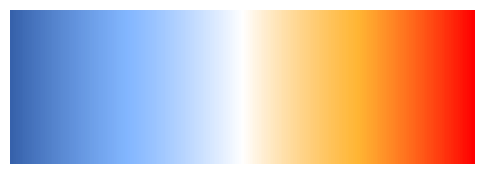

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import to_rgba
# Define the colors at specific points
colors = [
    (-1.8, "#120041"),  # Start with blue at -1.9
    (-1.2, "#2500fa"),
    (-0.6, "#84c6fd"),  # Start with blue at -1.9
    (0, "white"),    # Transition to white at 0
    (0.4, "#d50044"),
    (0.8, "#ff0000"),    # Start transitioning to red just after 0 towards 1.2
    (1.2, "#ffd400")  # End with yellow at 1.2
]

colors_with_opacity = [
    (-1.8, to_rgba("#3661ab", alpha=1.0)),  # Fully opaque
    (-0.9, to_rgba("#63a4ff", alpha=0.8)),  # Fully opaque
    # (-0.1, to_rgba("#008bff", alpha=0.6)),  # Fully opaque
    (0, to_rgba("white", alpha=1.0)),       # Fully opaque
    # (0.1, to_rgba("#d50044", alpha=0.6)),   # 30% opacity
    (0.6, to_rgba("#ffa300", alpha=0.8)),   # 60% opacity
    (1.2, to_rgba("#ff0000", alpha=1.0))    # Fully opaque
]



# Normalize the points to the [0, 1] interval
norm_points = np.linspace(-1.9, 1.2, len(colors_with_opacity))
norm_colors = [c[1] for c in colors_with_opacity]
norm_points = (norm_points - norm_points.min()) / (norm_points.max() - norm_points.min())

# Create a custom colormap
cmap = LinearSegmentedColormap.from_list("custom_gradient", list(zip(norm_points, norm_colors)))

# Create a gradient image
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

# Plot the gradient
fig, ax = plt.subplots(figsize=(6, 2))
ax.imshow(gradient, aspect='auto', cmap=cmap)
ax.set_axis_off()

plt.show()



# 0. load data

# if brain data exists, go to step 6.

# 6. (LOAD PARCEL DATA) load brain/beh data: use parcellated data for speed, for now

In [13]:
current_dir = os.getcwd()
current_dir
main_dir = Path(current_dir).parents[2] 
print(main_dir)
# /Users/h/Documents/projects_local/cue_expectancy/analysis/fmri/nilearn/deriv02_parcel-schaefer400/singletrial_rampupplateau_task-pvc_atlas-schaefer2018.npy'
braindf = np.load(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial_rampupplateau_task-pvc_atlas-schaefer2018.npy'))
print(f"the shape of the parcel data {braindf.shape}")
df_singletrial = pd.read_csv(join(main_dir, 'analysis/fmri/nilearn/deriv02_parcel-schaefer400', 'singletrial_rampupplateau_task-pvc_atlas-schaefer2018.tsv'), sep='\t')

schaefer = nnt_data.fetch_schaefer2018('fslr32k')['400Parcels7Networks']
parc = Parcellater(dlabel_to_gifti(schaefer), 'fsLR')

df_beh = pd.read_csv('/Users/h/Documents/projects_local/cue_expectancy/data/beh/sub-all_task-all_events.tsv', sep='\t')



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


/Users/h/Documents/projects_local/cue_expectancy
the shape of the parcel data (17111, 400)


# merge behavioral and single trial data

In [14]:
df_beh['singletrial_fname']
df_singletrial['index'] = df_singletrial.index
print(df_singletrial['singletrial_fname'][0])
print(df_beh['singletrial_fname'][0])

print(df_singletrial.shape)
print(df_beh.shape)

sub-0002_ses-03_run-02_runtype-pain_event-stimulus_trial-009_cuetype-high_stimintensity-high.nii.gz
sub-0002_ses-03_run-01_runtype-vicarious_event-stimulus_trial-000_cuetype-low_stimintensity-low.nii.gz
(17111, 10)
(17928, 12)


In [19]:

merged_df = pd.merge(df_singletrial, df_beh, on=["singletrial_fname", "sub", "ses", "run", "runtype"], how="inner")
print(merged_df.shape)
merged_df.head()


(17111, 17)


singletrial_fname       sub     ses  \
0  sub-0002_ses-03_run-02_runtype-pain_event-stim...  sub-0002  ses-03   
1  sub-0002_ses-04_run-05_runtype-cognitive_event...  sub-0002  ses-04   
2  sub-0002_ses-04_run-02_runtype-cognitive_event...  sub-0002  ses-04   
3  sub-0002_ses-04_run-05_runtype-cognitive_event...  sub-0002  ses-04   
4  sub-0002_ses-03_run-03_runtype-cognitive_event...  sub-0002  ses-03   

      run    runtype     event      trial cuetype stimintensity  index  \
0  run-02       pain  stimulus  trial-009    high          high      0   
1  run-05  cognitive  stimulus  trial-010     low           med      1   
2  run-02  cognitive  stimulus  trial-005     low           low      2   
3  run-05  cognitive  stimulus  trial-006     low          high      3   
4  run-03  cognitive  stimulus  trial-007    high          high      4   

   trial_index       cue stimulusintensity  expectrating  expectlabel  \
0           10  high_cue         high_stim         87.26  Very Strong   
1           11   low_cue          med_stim         40.19       Strong   
2            6   low_cue          low_stim           NaN          NaN   
3            7   low_cue         high_stim           NaN          NaN   
4            8  high_cue         high_stim         27.69     Moderate   

   outcomerating outcomelabel  
0          70.33  Very Strong  
1          46.57       Strong  
2            NaN          NaN  
3            NaN          NaN  
4           7.61         Weak

In [16]:
braindf[merged_df['index'].tolist()].shape

(17111, 400)

In [17]:
# make sure the beh+NPS data is in the parcel data


cleanbraindf = braindf[merged_df['index'].tolist()]
print(f"brain df shape: {cleanbraindf.shape}")
print(f"behavioral - brain intersection shape: {merged_df.shape}")


brain df shape: (17111, 400)
behavioral - brain intersection shape: (17111, 17)


# plot behavioral data

We're going to grab a subset of regressors. Here's just a demo of the regressors we can grab.
It has 
* 1) stimulus, inserted as a contrast code,
* 2) expectation rating, not yet z scored
* 3) outcome rating, not yet z scored.


In [20]:
print(f"column names: {merged_df.columns}")
print(f"take a look at the beh + NPS dataframe: {merged_df.head()}")

column names: Index(['singletrial_fname', 'sub', 'ses', 'run', 'runtype', 'event', 'trial',
       'cuetype', 'stimintensity', 'index', 'trial_index', 'cue',
       'stimulusintensity', 'expectrating', 'expectlabel', 'outcomerating',
       'outcomelabel'],
      dtype='object')
take a look at the beh + NPS dataframe:                                    singletrial_fname       sub     ses  \
0  sub-0002_ses-03_run-02_runtype-pain_event-stim...  sub-0002  ses-03   
1  sub-0002_ses-04_run-05_runtype-cognitive_event...  sub-0002  ses-04   
2  sub-0002_ses-04_run-02_runtype-cognitive_event...  sub-0002  ses-04   
3  sub-0002_ses-04_run-05_runtype-cognitive_event...  sub-0002  ses-04   
4  sub-0002_ses-03_run-03_runtype-cognitive_event...  sub-0002  ses-03   

      run    runtype     event      trial cuetype stimintensity  index  \
0  run-02       pain  stimulus  trial-009    high          high      0   
1  run-05  cognitive  stimulus  trial-010     low           med      1   
2  run-02  co

In [21]:
merged_df['stim_con'] = merged_df['stimulusintensity'].replace({'high_stim':1, 
                                           'med_stim':0, 
                                           'low_stim':-1})
merged_df['cue_con'] = merged_df['cue'].replace({'high_cue':1, 
                                           'low_cue':-1})         
cleanbehdf = merged_df
cleanbehdf.columns

Index(['singletrial_fname', 'sub', 'ses', 'run', 'runtype', 'event', 'trial',
       'cuetype', 'stimintensity', 'index', 'trial_index', 'cue',
       'stimulusintensity', 'expectrating', 'expectlabel', 'outcomerating',
       'outcomelabel', 'stim_con', 'cue_con'],
      dtype='object')

In [22]:
dummy_vars = pd.get_dummies(cleanbehdf['runtype'])
beh = pd.concat([cleanbehdf, dummy_vars], axis=1)
# outcome > expect "aversieve"
# outcome < expect "appetitive"
beh['PE'] = beh['outcomerating'] - beh['expectrating']
beh['absPE'] = beh['PE'].abs()
beh['aversivePE'] = np.where(beh['PE'] > 0, beh['PE'], 0)
beh['appetitivePE'] = np.where(beh['PE'] < 0, beh['PE'], 0)

beh.rename(columns={'pain': 'dummy_pain', 'vicarious': 'dummy_vicarious', 'cognitive': 'dummy_cognitive'}, inplace=True)
beh['dummy_general'] = 1 # adding domain general regressor
beh['pain_absPE'] = beh['dummy_pain'] * beh['absPE']
beh['vic_absPE'] = beh['dummy_vicarious'] * beh['absPE']
beh['cog_absPE'] = beh['dummy_cognitive'] * beh['absPE']
beh['gen_absPE'] = beh['dummy_general'] * beh['absPE']


singletrial = cleanbraindf  # zscored_braindf  # np.random.randn(89, 1)      # Replace with your actual data
# identify groups
from collections import Counter

# subject_ids = [int(re.search(r"sub-(\d+)", fname).group(1)) for fname in flist]
subject_counts = Counter(beh['sub'])  # Count the occurrences of each subject
factorized_ids, unique_ids = pd.factorize(beh['sub'])
groupsinterim = (
    factorized_ids + 1
) 


print(f"beh: {beh.shape} ")
print(f"Y: {singletrial.shape} ")
print(f"groups: {groupsinterim.shape} ")


beh: (17111, 31) 
Y: (17111, 400) 
groups: (17111,) 


In [23]:
# Re-importing pandas after reset
import pandas as pd
# Creating a DataFrame for mapping
df_mapping = pd.DataFrame({
    "group_id": range(1, len(unique_ids) + 1),
    "bids_id": unique_ids
})

df_mapping.head()

group_id   bids_id
0         1  sub-0002
1         2  sub-0005
2         3  sub-0013
3         4  sub-0014
4         5  sub-0015

# pe distribution

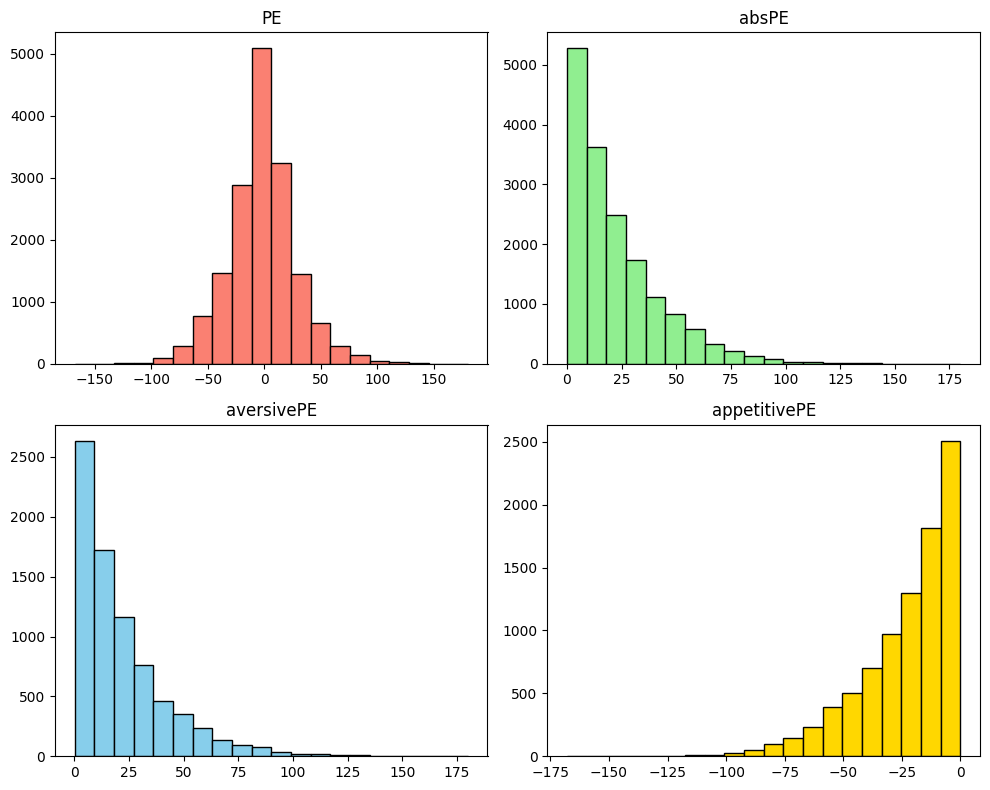

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))  # 2x2 grid, adjust size as needed

# Plotting the distributions
axs[0, 0].hist(beh['PE'][beh['PE'] != 0], bins=20, color='salmon', edgecolor='black')
axs[0, 0].set_title('PE')
axs[0, 1].hist(beh['absPE'][beh['absPE'] != 0], bins=20, color='lightgreen', edgecolor='black')
axs[0, 1].set_title('absPE')

axs[1, 0].hist(beh['aversivePE'][beh['aversivePE'] != 0], bins=20, color='skyblue', edgecolor='black')
axs[1, 0].set_title('aversivePE')

axs[1, 1].hist(beh['appetitivePE'][beh['appetitivePE'] != 0], bins=20, color='gold', edgecolor='black')
axs[1, 1].set_title('appetitivePE')

# Adjusting layout
plt.tight_layout()

# Show the plots
plt.show()

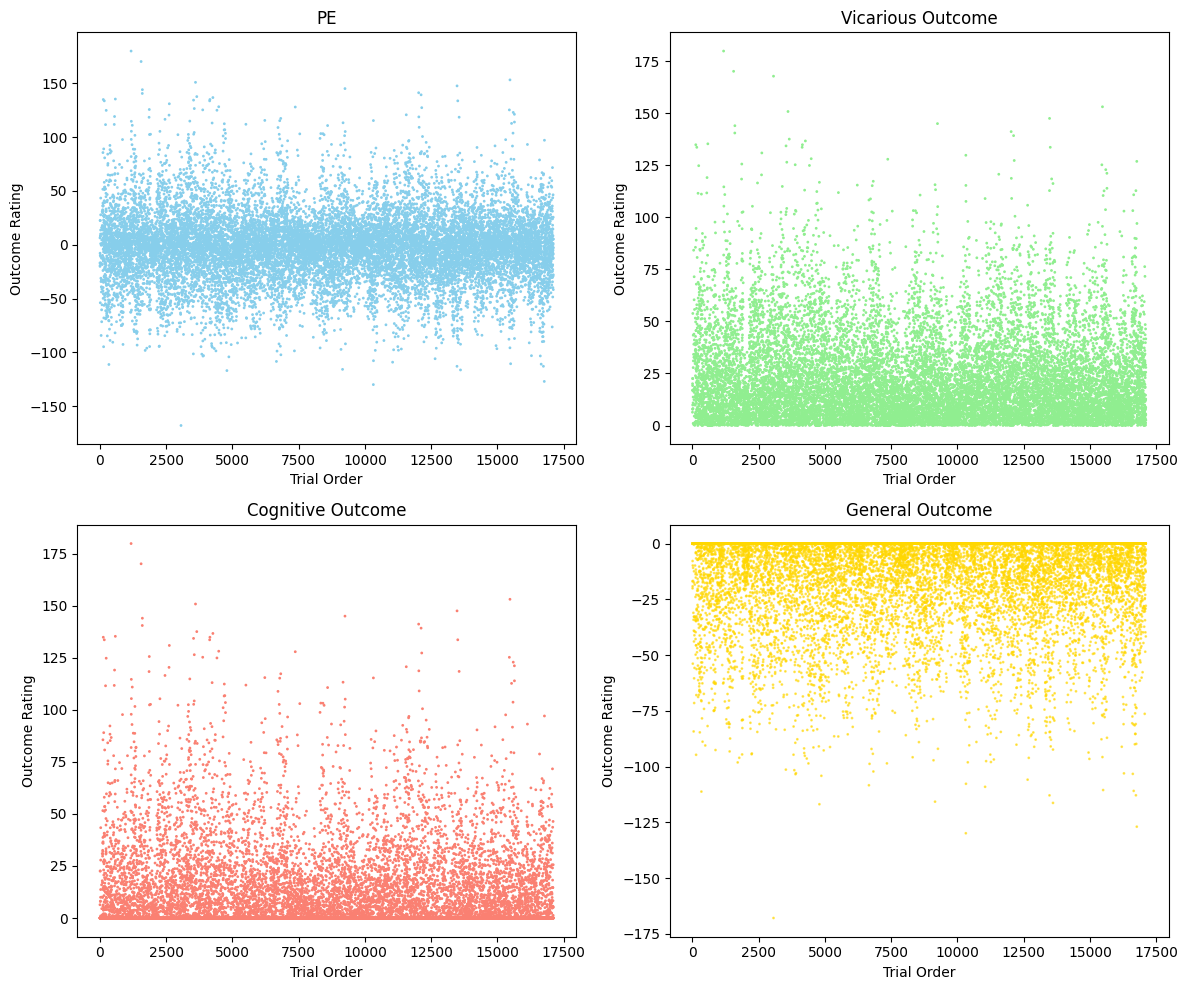

In [25]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(2, 2, figsize=(12, 10))  # 2x2 grid, adjust size as needed

# Plotting the outcomes across trials
axs[0, 0].scatter(beh.index, beh['PE'], s=1, marker='o', linestyle='', color='skyblue')
axs[0, 0].set_title('PE')
axs[0, 0].set_xlabel('Trial Order')
axs[0, 0].set_ylabel('Outcome Rating')

axs[0, 1].scatter(beh.index, beh['absPE'], s=1, marker='o', linestyle='', color='lightgreen')
axs[0, 1].set_title('Vicarious Outcome')
axs[0, 1].set_xlabel('Trial Order')
axs[0, 1].set_ylabel('Outcome Rating')

axs[1, 0].scatter(beh.index, beh['aversivePE'], s=1, marker='o', linestyle='', color='salmon')
axs[1, 0].set_title('Cognitive Outcome')
axs[1, 0].set_xlabel('Trial Order')
axs[1, 0].set_ylabel('Outcome Rating')

axs[1, 1].scatter(beh.index, beh['appetitivePE'], s=1, marker='o', linestyle='', color='gold', alpha=0.6)
axs[1, 1].set_title('General Outcome')
axs[1, 1].set_xlabel('Trial Order')
axs[1, 1].set_ylabel('Outcome Rating')

# Adjusting layout
plt.tight_layout()

# Show the plots
plt.show()

# incase we want to drop rows with NA
but based on https://learnche.org/pid/latent-variable-modelling/principal-component-analysis/preprocessing-the-data-before-building-a-model
for the initial analysis, include everything.

The general rule is: add as many columns into 
 as possible for the initial analysis. You can always prune out the columns later on if they are shown to be uninformative.

 The course of action when removing outliers is to always mark their values as missing just for that variable in 
, rather than removing the entire row in 
. We do this because we can use the algorithms to calculate the latent variable model when missing data are present within a row.

In [26]:
# remove nan values from X, Y, groups
import pandas as pd
Y_beh = ['pain_absPE', 'vic_absPE','cog_absPE', 'gen_absPE']  # PE appetitivePE aversivePE
# Assuming df_main is your primary DataFrame
nan_rows = beh[beh[Y_beh].isnull().any(axis=1)]
beh_dropna = beh.dropna()

singletrial_dropna= singletrial[beh_dropna.index.to_numpy()]
groups_dropna = groupsinterim[beh_dropna.index.to_numpy()]


In [27]:
print(f"X: {beh.shape} after dropping -> {beh_dropna.shape}")
print(f"Y: {singletrial.shape} after dropping -> {singletrial_dropna.shape}")
print(f"groups: {groupsinterim.shape} after dropping -> {groups_dropna.shape}")

X: (17111, 31) after dropping -> (15959, 31)
Y: (17111, 400) after dropping -> (15959, 400)
groups: (17111,) after dropping -> (15959,)


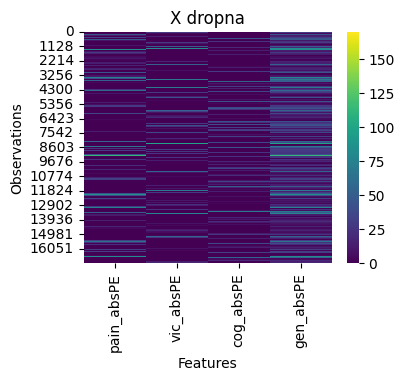

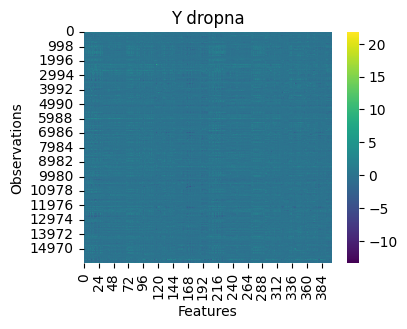

In [28]:

# Plotting
plt.figure(figsize=(4,3))
sns.heatmap(beh_dropna[Y_beh], cmap="viridis", cbar=True)
plt.title("X dropna")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()

plt.figure(figsize=(4,3))
sns.heatmap(singletrial_dropna, cmap="viridis", cbar=True)
plt.title("Y dropna")
plt.xlabel("Features")
plt.ylabel("Observations")
plt.show()


# --PLS for Pain related variables--

In [29]:
beh_dropna.columns

Index(['singletrial_fname', 'sub', 'ses', 'run', 'runtype', 'event', 'trial',
       'cuetype', 'stimintensity', 'index', 'trial_index', 'cue',
       'stimulusintensity', 'expectrating', 'expectlabel', 'outcomerating',
       'outcomelabel', 'stim_con', 'cue_con', 'dummy_cognitive', 'dummy_pain',
       'dummy_vicarious', 'PE', 'absPE', 'aversivePE', 'appetitivePE',
       'dummy_general', 'pain_absPE', 'vic_absPE', 'cog_absPE', 'gen_absPE'],
      dtype='object')

In [30]:
def get_bids_id_from_group_id(dataframe, group_id):
    # Filter the DataFrame for the given group_id
    filtered_df = dataframe[dataframe['group_id'] == group_id]
    
    # Check if there's at least one match
    if not filtered_df.empty:
        # Assuming group_id is unique, there should be only one matching row
        return filtered_df['bids_id'].iloc[0]
    else:
        return None  # Or any suitable value indicating th

In [36]:
from sklearn.model_selection import GroupKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assuming X, Y, and groups are already defined ________________________________
X =singletrial_dropna # (trials x Brain either voxels or parcels)
Y = beh_dropna[Y_beh] #(trials x ratings)
groups =groups_dropna

n_components_range = range(9, 10)  # Adjust the range as needed
outer_cv = GroupKFold(n_splits=10)
results_df = pd.DataFrame(columns=['Fold', 'Component','SubjectID', 'groupIDSubject', 'MSE', 'R2', 
                                   'Y_pred_subj','Y_test_subj','x_weights', 'x_loadings','y_weights',
                                    'y_loadings','Intercept', 'Coef' ])

scaler = StandardScaler()

# Main loop for GroupKFold splits
model_coefs = []
model_intercept = []
y_preds = []
bids_ids = []
y_preds_fold = []
mse_fold = []
r2_fold = []
test_ind = []
beta_per_fold = []
n_components=10
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):

    print(f"Fold {fold + 1}")
    fold_model_coefs = []
    fold_model_intercept = []

    # Split data into training and test sets ___________________________________
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y.iloc[train_idx].to_numpy(), Y.iloc[test_idx].to_numpy()
    groups_train = groups[train_idx]
    groups_test = groups[test_idx]
    print(f"{X_train.shape} {Y_train.shape} {X_test.shape} {Y_test.shape} ")

    # build model per subject _______________________________________________________

    for subject in np.unique(groups_train).tolist(): #groups_test.unique():
        # Select data for the current subject
        subject_idx = groups_train[groups_train == subject]
        subject_mask = (groups_train == subject)
        # print(np.unique(subject_idx)[0])
        bids_id = get_bids_id_from_group_id(df_mapping, np.unique(subject_idx)[0])
        print(f"{bids_id}")
        bids_ids.append(bids_id)
        X_train_subj = X_train[subject_mask]
        Y_train_subj = Y_train[subject_mask]

        # X_train_subj_scaled = scaler.fit_transform(X_train_subj)
        # X_test_subj_scaled = scaler.transform(X_test_subj)

        pls_subj = PLSRegression(n_components=n_components)
        pls_subj.fit(X_train_subj, Y_train_subj)

        fold_model_coefs.append(pls_subj.coef_)
        fold_model_intercept.append(pls_subj.intercept_)
        # y_preds.append(Y_pred_train_subj) # N subj

    # get X tests and Y tests

    print({len(fold_model_coefs)}, {len(fold_model_intercept)}, {len(y_preds)})
    # stack_model_per_fold = np.vstack(fold_model_coefs)
    # average the model per fold _______________________________________________
    mean_coef = np.mean(np.stack(fold_model_coefs),axis=0)
    mean_int = np.mean(fold_model_intercept, axis=0)
    print(f"fold average coef, intercept shape: {mean_coef.shape}, {mean_int.shape}")

    #Y_pred = pls_subj.predict(X_test)
    # calculate model performance_______________________________________________
    # Here, we calculate Yprd, MSE, R2 per fold. 
    Y_pred_fold = np.dot(X_test, mean_coef.T) + mean_int
    print(f"y pred shape: {Y_pred_fold.shape}")
    mse_fold.append(mean_squared_error(Y_test, Y_pred_fold))
    r2_fold.append(r2_score(Y_test, Y_pred_fold))
    y_preds.append(Y_pred_fold)
    test_ind.append(groups_test)
    print(f"{mse_fold}, \n{r2_fold}")

    XTX_inv = np.linalg.inv(X_test.T.dot(X_test))
    XTY = X_test.T.dot(Y_test)#Y_pred_fold)
    beta = XTX_inv.dot(XTY)
    beta_per_fold.append(beta)

Fold 1
(14369, 400) (14369, 4) (1590, 400) (1590, 4) 
sub-0002
sub-0013
sub-0015
sub-0016
sub-0017
sub-0018
sub-0019
sub-0021
sub-0023
sub-0024
sub-0025
sub-0026
sub-0028
sub-0029
sub-0030
sub-0031
sub-0032
sub-0033
sub-0035
sub-0036
sub-0037
sub-0038
sub-0039
sub-0040
sub-0041
sub-0043
sub-0044
sub-0047
sub-0050
sub-0051
sub-0052
sub-0053
sub-0056
sub-0057
sub-0058
sub-0059
sub-0060
sub-0061
sub-0062
sub-0064
sub-0066
sub-0068
sub-0069
sub-0070
sub-0071
sub-0073
sub-0074
sub-0075
sub-0076
sub-0077
sub-0078
sub-0079
sub-0080
sub-0081
sub-0082
sub-0083
sub-0084
sub-0085
sub-0087
sub-0089
sub-0090
sub-0091
sub-0092
sub-0093
sub-0094
sub-0095
sub-0098
sub-0099
sub-0100
sub-0102
sub-0103
sub-0104
sub-0106
sub-0107
sub-0111
sub-0112
sub-0114
sub-0115
sub-0116
sub-0118
sub-0120
sub-0122
sub-0123
sub-0124
sub-0126
sub-0127
sub-0128
sub-0130
sub-0131
sub-0132
sub-0133
{91} {91} {0}
fold average coef, intercept shape: (4, 400), (4,)
y pred shape: (1590, 4)
[252.78733898038027], 
[0.129609725047

In [37]:
print(f"{X_test.shape} {mean_coef.shape}")

(1606, 400) (4, 400)


# source reconstruction

In [38]:
Y_beh

['pain_absPE', 'vic_absPE', 'cog_absPE', 'gen_absPE']

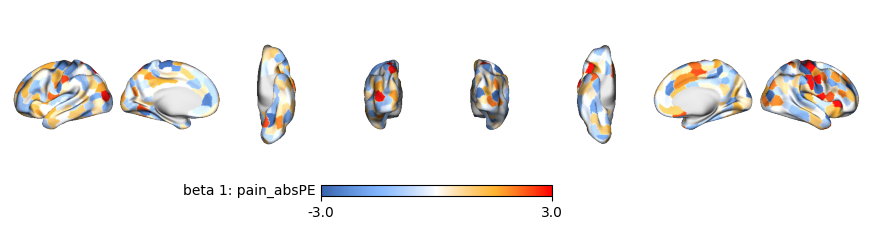

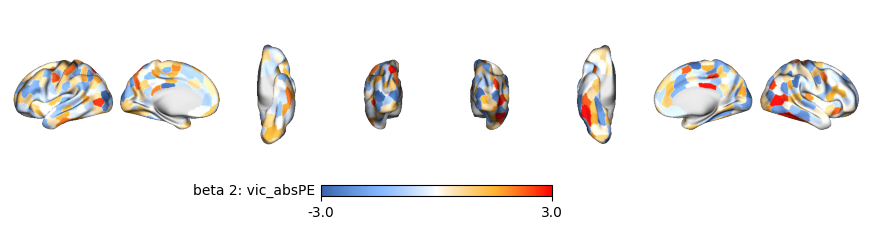

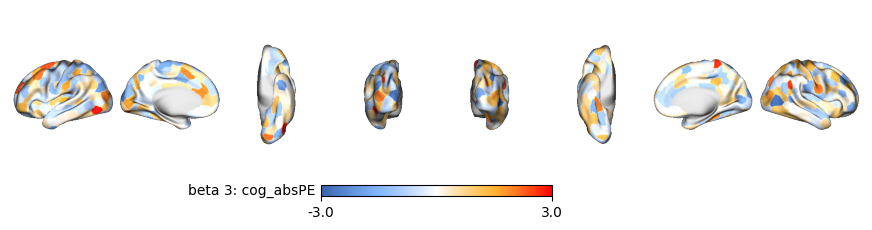

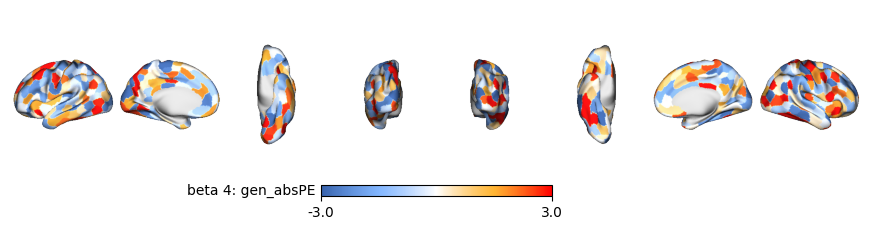

In [39]:
avg_beta_mat = np.mean(np.stack(beta_per_fold), axis=0)
factor_name = Y_beh
# color_range = [(0.95, 1.05),(-0.04, 0.075),(2.5, 9.5), (3,9), (.55, 1.15) ]
for beta_ind in range(len(factor_name)):
    beta_i = avg_beta_mat[:, beta_ind]
    beta_inv = parc.inverse_transform(beta_i)
    # plt.hist(beta)
    fig = plot_brain_surfaces(image=beta_inv, cbar_label=f'beta {beta_ind+1}: {factor_name[beta_ind]}', cmap=cmap, color_range=(-3,3) )#color_range[beta_ind])
    plt.show()

In [40]:
X_test.shape

(1606, 400)

In [28]:
results_df.to_csv('./PLS_decodingPVCG_PE_mse.tsv', sep='\t', index=False)

# add component innerloop

In [ ]:
from sklearn.model_selection import GroupKFold
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

# Assuming X, Y, and groups are already defined ________________________________
X =singletrial_dropna # (trials x Brain either voxels or parcels)
Y = beh_dropna[Y_beh] #(trials x ratings)
groups =groups_dropna

n_components_range = range(9, 10)  # Adjust the range as needed
outer_cv = GroupKFold(n_splits=10)
results_df = pd.DataFrame(columns=['Fold', 'Component','SubjectID', 'groupIDSubject', 'MSE', 'R2', 
                                   'Y_pred_subj','Y_test_subj','x_weights', 'x_loadings','y_weights',
                                    'y_loadings','Intercept', 'Coef' ])

scaler = StandardScaler()

# Main loop for GroupKFold splits
model_coefs = []
model_intercept = []
y_preds = []
bids_ids = []
y_preds_fold = []
mse_fold = []
r2_fold = []
test_ind = []
beta_per_fold = []
n_components=10
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):

    print(f"Fold {fold + 1}")
    fold_model_coefs = []
    fold_model_intercept = []
    bids_id = []
    
    # Split data into training and test sets ___________________________________
    X_train, X_test = X[train_idx], X[test_idx]
    Y_train, Y_test = Y.iloc[train_idx].to_numpy(), Y.iloc[test_idx].to_numpy()
    groups_train = groups[train_idx]
    groups_test = groups[test_idx]
    print(f"{X_train.shape} {Y_train.shape} {X_test.shape} {Y_test.shape} ")

    # build model per subject _______________________________________________________
    ################# inner loop n components
    for n_components in n_components_range:
        print(f"Testing {n_components} components")
        mse_per_fold = []
        r2_fold = []
        y_preds = []

    #################
        for subject in np.unique(groups_train).tolist(): #groups_test.unique():
            # Select data for the current subject
            subject_idx = groups_train[groups_train == subject]
            subject_mask = (groups_train == subject)
            # print(np.unique(subject_idx)[0])
            bids_id = get_bids_id_from_group_id(df_mapping, np.unique(subject_idx)[0])
            print(f"{bids_id}")
            bids_ids.append(bids_id)
            X_train_subj = X_train[subject_mask]
            Y_train_subj = Y_train[subject_mask]

            # X_train_subj_scaled = scaler.fit_transform(X_train_subj)
            # X_test_subj_scaled = scaler.transform(X_test_subj)

            pls_subj = PLSRegression(n_components=n_components)
            pls_subj.fit(X_train_subj, Y_train_subj)

            fold_model_coefs.append(pls_subj.coef_)
            fold_model_intercept.append(pls_subj.intercept_)
            # y_preds.append(Y_pred_train_subj) # N subj

        # get X tests and Y tests

        print({len(fold_model_coefs)}, {len(fold_model_intercept)}, {len(y_preds)})
        # stack_model_per_fold = np.vstack(fold_model_coefs)
        # average the model per fold _______________________________________________
        mean_coef = np.mean(np.stack(fold_model_coefs),axis=0)
        mean_int = np.mean(fold_model_intercept, axis=0)
        print(f"fold average coef, intercept shape: {mean_coef.shape}, {mean_int.shape}")

        #Y_pred = pls_subj.predict(X_test)
        # calculate model performance_______________________________________________
        # Here, we calculate Yprd, MSE, R2 per fold. 
        Y_pred_fold = np.dot(X_test, mean_coef.T) + mean_int
        print(f"y pred shape: {Y_pred_fold.shape}")
        mse_per_fold.append(mean_squared_error(Y_test, Y_pred_fold))
        r2_fold.append(r2_score(Y_test, Y_pred_fold))
        y_preds.append(Y_pred_fold)
        # test_ind.append(groups_test)
        print(f"{mse_per_fold}, \n{r2_fold}")

        XTX_inv = np.linalg.inv(X_test.T.dot(X_test))
        XTY = X_test.T.dot(Y_test)#Y_pred_fold)
        beta = XTX_inv.dot(XTY)
        beta_per_fold.append(beta)
        results_df = pd.DataFrame({'Fold': fold, 
                                   'Component': int(n_components +1),
                                   'SubjectID': bids_ids, 
                                   'test_id': , 
                                   'groupIDSubject', 
                                   'MSE': mse_per_fold, 
                                   'R2', 
                                   'Y_pred_subj',
                                   'Y_test_subj',
                                   'x_weights', 
                                   'x_loadings',
                                   'y_weights', 
                                   'y_loadings',
                                   'Intercept', 
                                   'Coef' : [beta_per_fold]})

In [ ]:
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GroupKFold


X = singletrial_dropna
Y = centered_matrix
groups = groups_dropna
# Initialize variables for storing results
n_components_range = range(1, 50)  # Adjust the range as needed
mean_mse_per_component = []

# Outer CV setup
outer_cv = GroupKFold(n_splits=10)



for train_val_idx, test_idx in outer_cv.split(X, Y, groups):
    X_train, X_test = X[train_val_idx], X[test_idx]
    Y_train, Y_test = Y.iloc[train_val_idx].to_numpy(), Y.iloc[test_idx].to_numpy()

################# inner loop n components
    for n_components in n_components_range:
        print(f"Testing {n_components} components")
        mse_per_fold = []
#################
    # Initialize PLSRegression with the current number of components
        pls_model = PLSRegression(n_components=n_components)

        # Fit the model
        pls_model.fit(X_train, Y_train)

    # Predict and calculate MSE
    Y_pred = pls_model.predict(X_test)
    # Y_pred and Y_error per fold X No.Comp 
    # TODO: save Y_pred per fold
    mse = mean_squared_error(Y_test, Y_pred)
    mse_per_fold.append(mse)

# Calculate mean MSE for the current number of components
mean_mse = np.mean(mse_per_fold)
mean_mse_per_component.append(mean_mse)
print(f"Mean MSE for {n_components} components: {mean_mse}")




> This looks promixing <br>
> The MSE does kick back up a little, which would be signs of overfitting.
From these plots, I choose a component of XX


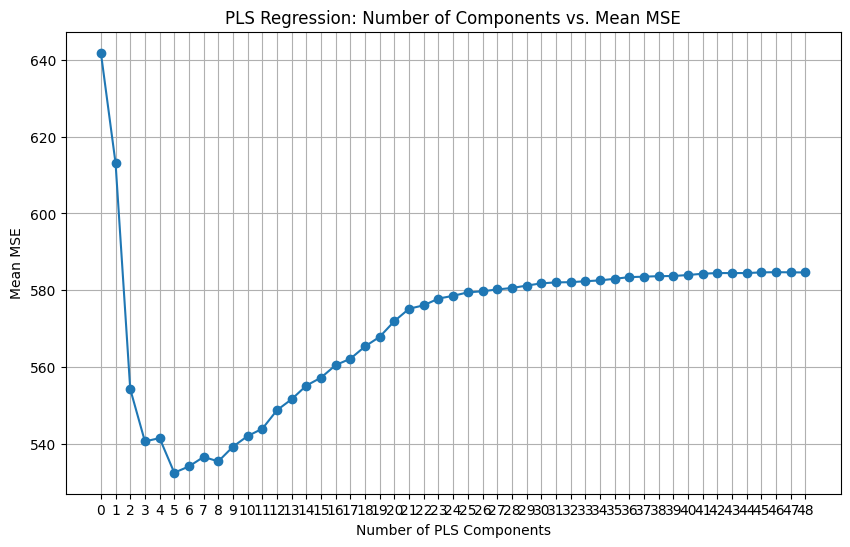

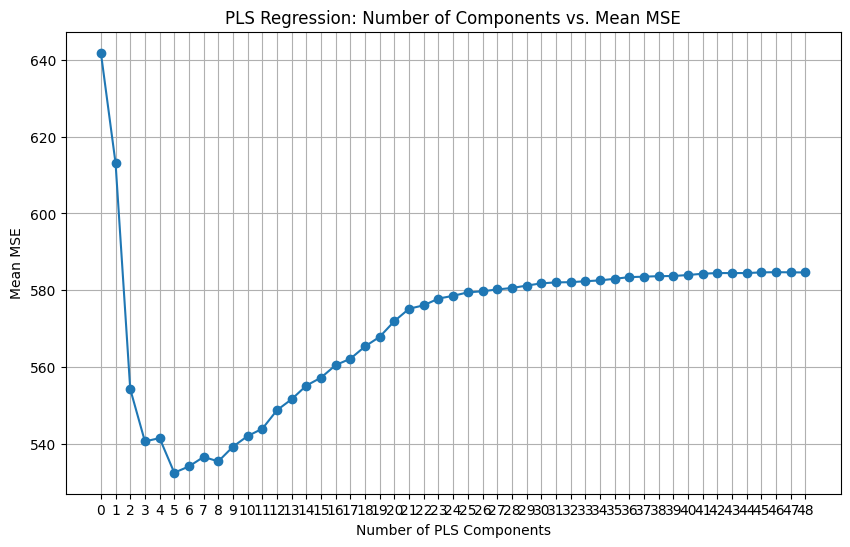

In [158]:
# After iterating over all component numbers, you can plot the MSE to find the elbow point
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(mean_mse_per_component)), mean_mse_per_component, marker='o')
plt.xlabel('Number of PLS Components')
plt.ylabel('Mean MSE')
plt.title('PLS Regression: Number of Components vs. Mean MSE')
plt.xticks(np.arange(len(mean_mse_per_component)))
plt.grid(True)
plt.show()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(mean_mse_per_component[:50])), mean_mse_per_component[:50], marker='o')
plt.xlabel('Number of PLS Components')
plt.ylabel('Mean MSE')
plt.title('PLS Regression: Number of Components vs. Mean MSE')
plt.xticks(np.arange(len(mean_mse_per_component[:50])))
plt.grid(True)
plt.show()

## PLS with 10 components

In [160]:
PLScomp = 10

In [161]:
# X = singletrial_dropna # singletrial
# beh = beh_dropna[["cue_con","stim_con", "expectrating", "outcomerating", "NPSpos"]] #beh
# Y = beh-beh.median(axis=0)
# groups = groups_dropna
X = singletrial_dropna
Y = centered_matrix
groups = groups_dropna
from sklearn.metrics import r2_score
outer_cv = GroupKFold(n_splits=10)

pls_model = PLSRegression(n_components=PLScomp)
i = 0
inner_scores = []
outer_scores = []
x_weights_per_fold = []
y_weights_per_fold = []
x_loadings_per_fold = []
y_loadings_per_fold = []
intercepts_per_fold = []
coefficients_per_fold = []
mse_per_fold = []
R2_per_fold = []
# X = braindf
# Y = reg
for i, (train_val_idx, test_idx) in enumerate(outer_cv.split(X, Y, groups)):
    print(f"________________________________ fold {i} ________________________________")
    X_train, X_test = X[train_val_idx], X[test_idx]
    Y_train, Y_test = Y.iloc[train_val_idx].to_numpy(), Y.iloc[test_idx].to_numpy()
    groups_train_val = groups[train_val_idx]
    print(
        f"train participants: {np.unique(groups[train_val_idx])},test participants: {np.unique(groups[test_idx])}, "
    )
    # Fit the model
    pls_model.fit(X_train, Y_train)
    r2 = pls_model.score(X_train, Y_train)
    R2_per_fold.append(r2)

    # Evaluate on the inner validation set
    Y_pred = pls_model.predict(X_test)
    mse = mean_squared_error(Y_test, Y_pred)
    mse_per_fold.append(mse)
    # Assuming the nifti_masker has been fitted previously

    x_weights_per_fold.append(pls_model.x_weights_)
    y_weights_per_fold.append(pls_model.y_weights_)

    x_loadings_per_fold.append(pls_model.x_loadings_)
    y_loadings_per_fold.append(pls_model.y_loadings_)

    intercepts_per_fold.append(pls_model.intercept_)
    coefficients_per_fold.append(pls_model.coef_)


________________________________ fold 0 ________________________________
train participants: [  1   2   3   4   5   6   7   8   9  10  11  13  14  15  16  17  18  19
  20  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  46  47  48  49  50  51  52  54  55  56  57  59  60
  62  63  64  65  66  67  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  84  85  86  87  88  90  91  92  93  94  95  96  97  98  99 100
 101 103 104 105 106 107 109 110 111],test participants: [ 12  21  24  45  58  61  68  83  89 102 108], 
________________________________ fold 1 ________________________________
train participants: [  1   3   4   5   6   7   8   9  10  12  13  14  15  17  18  19  20  21
  22  23  24  25  27  28  29  30  32  34  35  36  37  38  39  40  42  43
  44  45  46  48  49  50  51  52  54  56  57  58  59  60  61  62  63  64
  65  66  67  68  69  71  72  73  74  75  76  77  78  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97

### A. R2 per fold

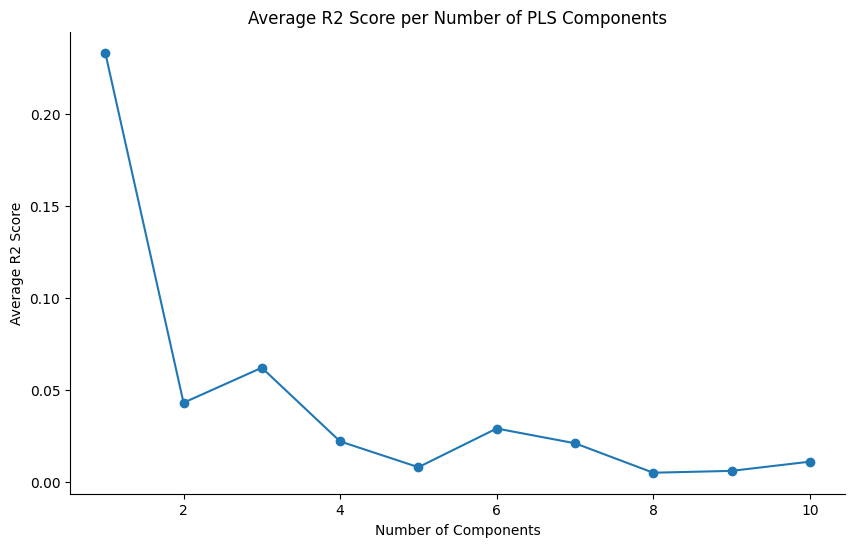

In [162]:
from sklearn.metrics import r2_score
r2_list = []
for i in range(0,PLScomp):
    Y_predict=np.dot(pls_model.x_scores_[:,i].reshape(-1,1),pls_model.y_loadings_[:,i].reshape(-1,1).T)*Y_train.std(axis=0, ddof=1)+Y_train.mean(axis=0)
    r2 = round(r2_score(Y_train,Y_predict, multioutput='variance_weighted'),3) 
    r2_list.append(r2)
    # print('R2 for %d component: %g' %(i+1,round(r2_score(Y_train,Y_predict),3)))


max_components = PLScomp
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_components + 1), r2_list, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Average R2 Score')
plt.title('Average R2 Score per Number of PLS Components')
sns.despine()
plt.show()

In [163]:

print(f"average R2: {np.mean(R2_per_fold)}")
R2_per_fold

average R2: 0.42186116717973654


[0.42432448652766375,
 0.4141404337264622,
 0.413868724541373,
 0.42169331831792367,
 0.4221599522969766,
 0.41968571801762783,
 0.4298902518762644,
 0.4268108767183534,
 0.42519322339840365,
 0.4208446863763167]

In [164]:

print(f"X weights: {x_weights_per_fold[0].shape}")
print(f"X loadings: {x_loadings_per_fold[0].shape}")
print(f"Y weights: {y_weights_per_fold[0].shape}")
print(f"Y loadings: {y_loadings_per_fold[0].shape}")
print(f"beta coef: {coefficients_per_fold[0].shape}")

X weights: (400, 10)
X loadings: (400, 10)
Y weights: (4, 10)
Y loadings: (4, 10)
beta coef: (4, 400)


### b. X weights per fold

average correlation across folds? :0.46475637746707577


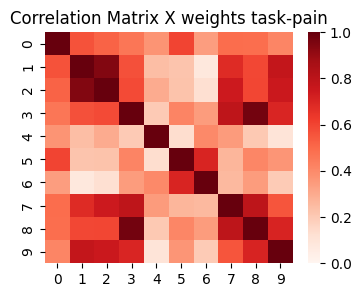

In [165]:
# convert correlation into a weight matrix ____________________________________
flattened_arrays = [arr.flatten() for arr in x_weights_per_fold]
corr_matrix = np.zeros((10, 10))

# Compute the correlation between each pair of flattened arrays
for i in range(10):
    for j in range(10):
        if i != j:
            # Use np.corrcoef to get the correlation coefficient matrix and take the [0, 1] value for the correlation
            corr_matrix[i, j] = np.corrcoef(flattened_arrays[i], flattened_arrays[j])[0, 1]
        else:
            # The correlation of an array with itself is always 1
            corr_matrix[i, j] = 1

corr_matrix
# calculate average correlation ____________________________________
upper_tri_indices = np.triu_indices(n=corr_matrix.shape[0], k=1)
# Extract the upper triangular values from the correlation matrix
upper_tri_values = corr_matrix[upper_tri_indices]
# Calculate the mean of these values
mean_pairwise_correlation = np.mean(upper_tri_values)
print(f"average correlation across folds? :{mean_pairwise_correlation}")
 
# plot correlation coefficients ____________________________________
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix,cmap='Reds', cbar=True, cbar_kws={} , vmin=0, vmax=1)
plt.title(f'Correlation Matrix X weights task-pain')
plt.show()

### c. X loadings per fold (correlation)
Are the loadings similar across folds?
> somewhat. average loading is .3 across folds

average correlation across folds? :0.46657137969270096


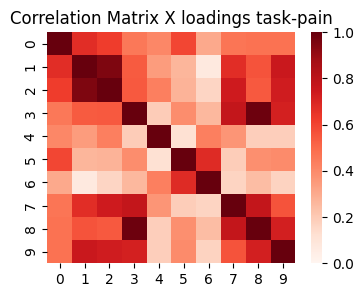

In [166]:
# convert correlation into a weight matrix ____________________________________
# corr_matrix = np.corrcoef(weights_class_1.T, rowvar=False)
flattened_arrays = [arr.flatten() for arr in x_loadings_per_fold]
corr_matrix = np.zeros((10, 10))

for i in range(10):
    for j in range(10):
        if i != j:
            # Use np.corrcoef to get the correlation coefficient matrix and take the [0, 1] value for the correlation
            corr_matrix[i, j] = np.corrcoef(flattened_arrays[i], flattened_arrays[j])[0, 1]
        else:
            # The correlation of an array with itself is always 1
            corr_matrix[i, j] = 1

corr_matrix
# calculate average correlation ____________________________________
upper_tri_indices = np.triu_indices(n=corr_matrix.shape[0], k=1)
upper_tri_values = corr_matrix[upper_tri_indices]
mean_pairwise_correlation = np.mean(upper_tri_values)
print(f"average correlation across folds? :{mean_pairwise_correlation}")
 
# plot correlation coefficients ____________________________________
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix,cmap='Reds', cbar=True, cbar_kws={} , vmin=0, vmax=1)
plt.title(f'Correlation Matrix X loadings task-pain')
plt.show()

### d. coeffiients across fold (correlation)
> Beta coefficients across folds are highly similar, r = .92

average correlation across folds? :0.9276201444232702


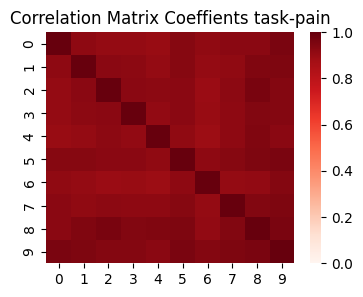

In [167]:
# convert correlation into a weight matrix ____________________________________
flattened_arrays = [arr.flatten() for arr in coefficients_per_fold]
corr_matrix = np.zeros((10, 10))

# Compute the correlation between each pair of flattened arrays
for i in range(10):
    for j in range(10):
        if i != j:
            # Use np.corrcoef to get the correlation coefficient matrix and take the [0, 1] value for the correlation
            corr_matrix[i, j] = np.corrcoef(flattened_arrays[i], flattened_arrays[j])[0, 1]
        else:
            # The correlation of an array with itself is always 1
            corr_matrix[i, j] = 1

# calculate average correlation ____________________________________
upper_tri_indices = np.triu_indices(n=corr_matrix.shape[0], k=1)
upper_tri_values = corr_matrix[upper_tri_indices]
mean_pairwise_correlation = np.mean(upper_tri_values)
print(f"average correlation across folds? :{mean_pairwise_correlation}")
 
# plot correlation coefficients ____________________________________
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix,cmap='Reds', cbar=True, cbar_kws={}, vmin=0, vmax=1)
plt.title(f'Correlation Matrix Coeffients task-pain')
plt.show()

## B.4 visualization (scores)

### B.4.a scores

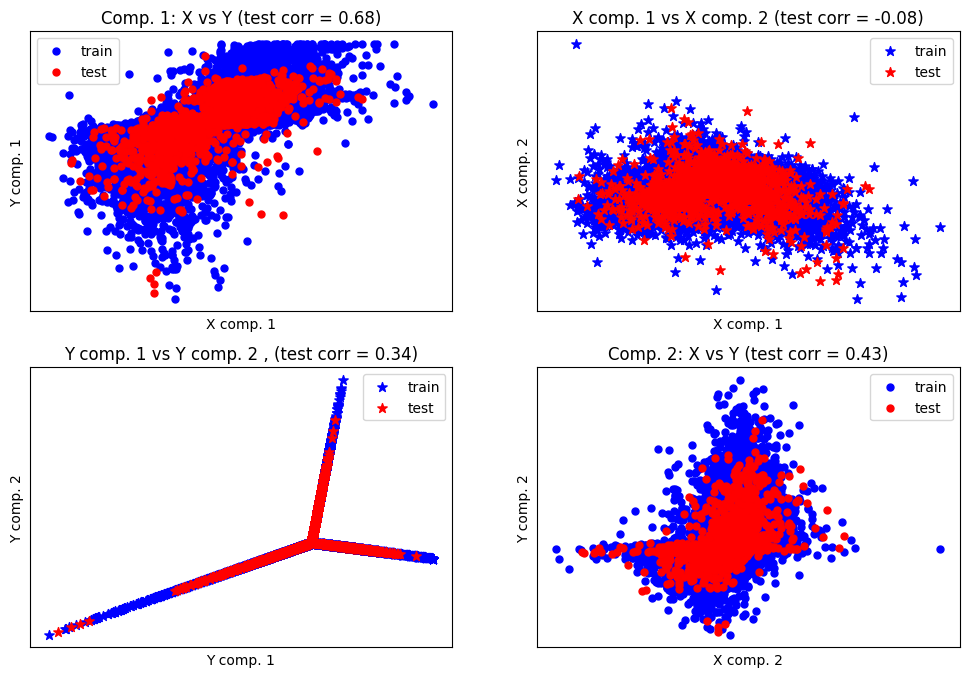

In [168]:
X_train_r, Y_train_r = pls_model.transform(X_train, Y_train)
X_test_r, Y_test_r = pls_model.transform(X_test, Y_test)
plot_scores(X_train_r, Y_train_r, X_test_r, Y_test_r)

# B.4.b plot loadings X & Y scores (U and T scores. )
Need the U scores to convert the 
X scores -> predictU scores
use Y loadings to convert U scores into Y scores

## X scores & Y scores T & U

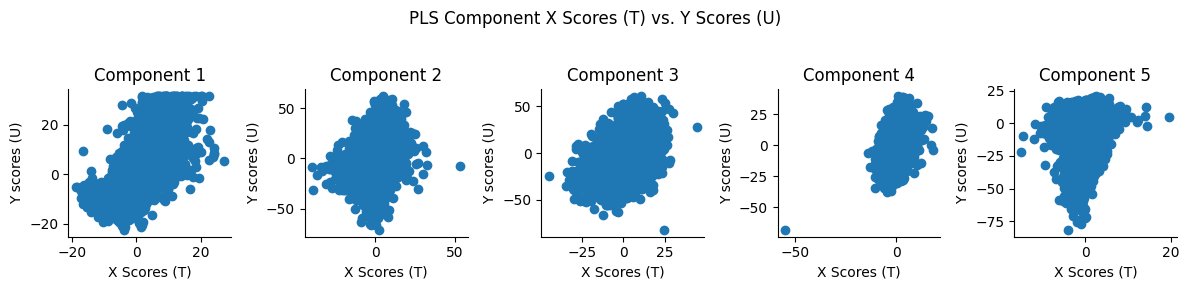

In [169]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(12, 3))  # Adjust the figsize accordingly
fig.suptitle('PLS Component X Scores (T) vs. Y Scores (U)', fontsize=12)
for i in range(5):
    # plt.figure(figsize=(4,3))
    ax = axes[i]
    ax.scatter(pls_model.x_scores_[:, i], pls_model.y_scores_[:, i])
    ax.set_xlabel(f'X Scores (T)')
    ax.set_ylabel(f'Y scores (U)')
    ax.set_title(f'Component {i+1}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
sns.despine()
plt.show()

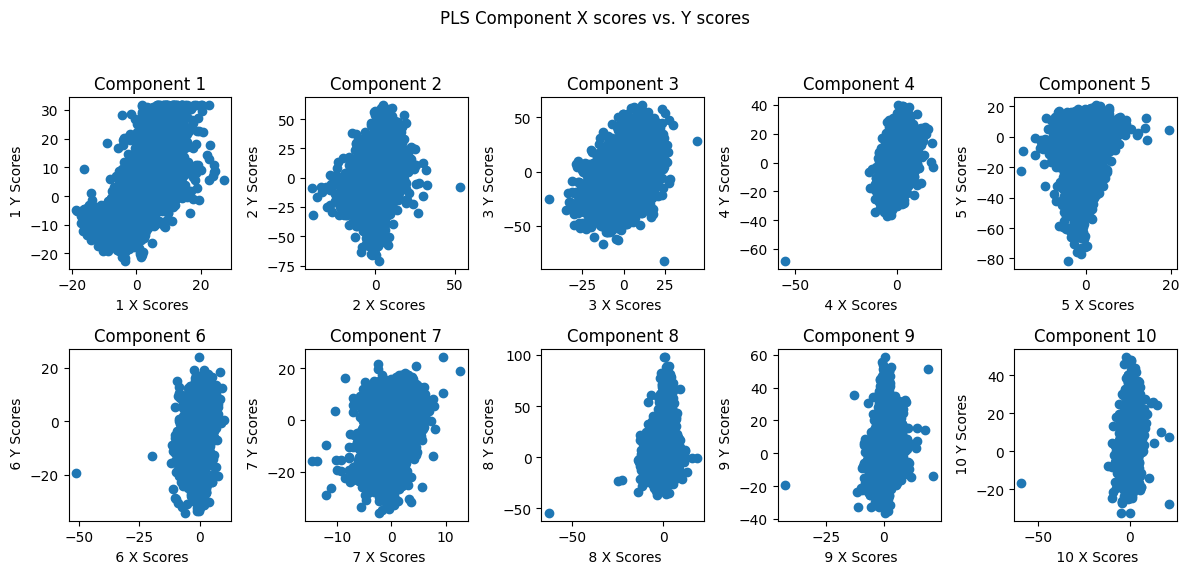

In [173]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))  # Adjust the figsize accordingly
fig.suptitle('PLS Component X scores vs. Y scores', fontsize=12)

# Loop through all subplots to fill them with scatter plots of corresponding PLS component scores
for i in range(2):  # Rows
    for j in range(5):  # Columns
        ax = axes[i, j]
        comp_index = i * 5 + j  # Calculate the index of the component (0 to 19)
        ax.scatter(pls_model.x_scores_[:, comp_index], pls_model.y_scores_[:, comp_index])
        ax.set_xlabel(f' {comp_index + 1} X Scores')
        ax.set_ylabel(f' {comp_index + 1} Y Scores')
        ax.set_title(f'Component {comp_index + 1}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
plt.show()

# (2) X loadings
Not sure what the X leadings tells us#

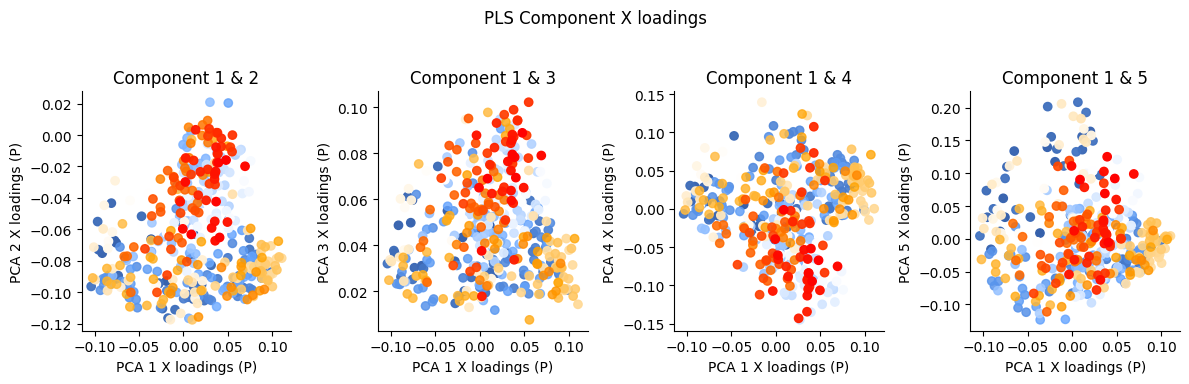

In [174]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12, 4))  # Adjust the figsize accordingly
fig.suptitle('PLS Component X loadings', fontsize=12)
n_features = pls_model.x_loadings_.shape[0] 
indices = np.arange(n_features)
for i in range(4):
    # plt.figure(figsize=(4,3))
    ax = axes[i]
    ax.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, i+1], c=indices, cmap=cmap)
    ax.set_xlabel(f'PCA 1 X loadings (P)')
    ax.set_ylabel(f'PCA {i+2} X loadings (P)')
    ax.set_title(f'Component 1 & {i+2}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
sns.despine()
plt.show()

# (3) Y loadings
each of the Y loadings illustrate the relationship between the original Y variables and the deomposed components. 
The Y loadings describe how much each varibale in the Y matrix contributes to each component.

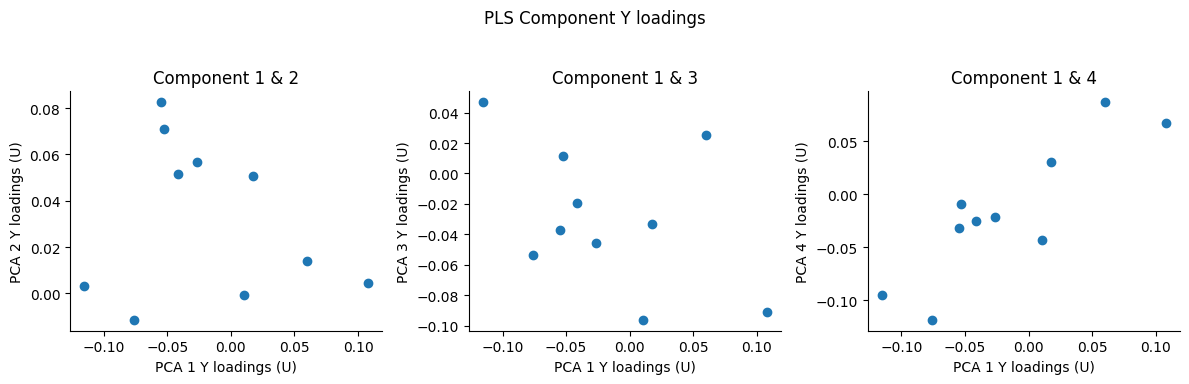

In [177]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))  # Adjust the figsize accordingly
fig.suptitle('PLS Component Y loadings', fontsize=12)
n_features = pls_model.y_loadings_.shape[1] 
indices = np.arange(n_features)
for i in range(3):
    # plt.figure(figsize=(4,3))
    ax = axes[i]
    ax.scatter(pls_model.y_loadings_[0,:], pls_model.y_loadings_[i+1, ]) #, c=indices, cmap=cmap)
    ax.set_xlabel(f'PCA 1 Y loadings (U)')
    ax.set_ylabel(f'PCA {i+2} Y loadings (U)')
    ax.set_title(f'Component 1 & {i+2}')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
sns.despine()
plt.show()

# (4) Y loadings per factors

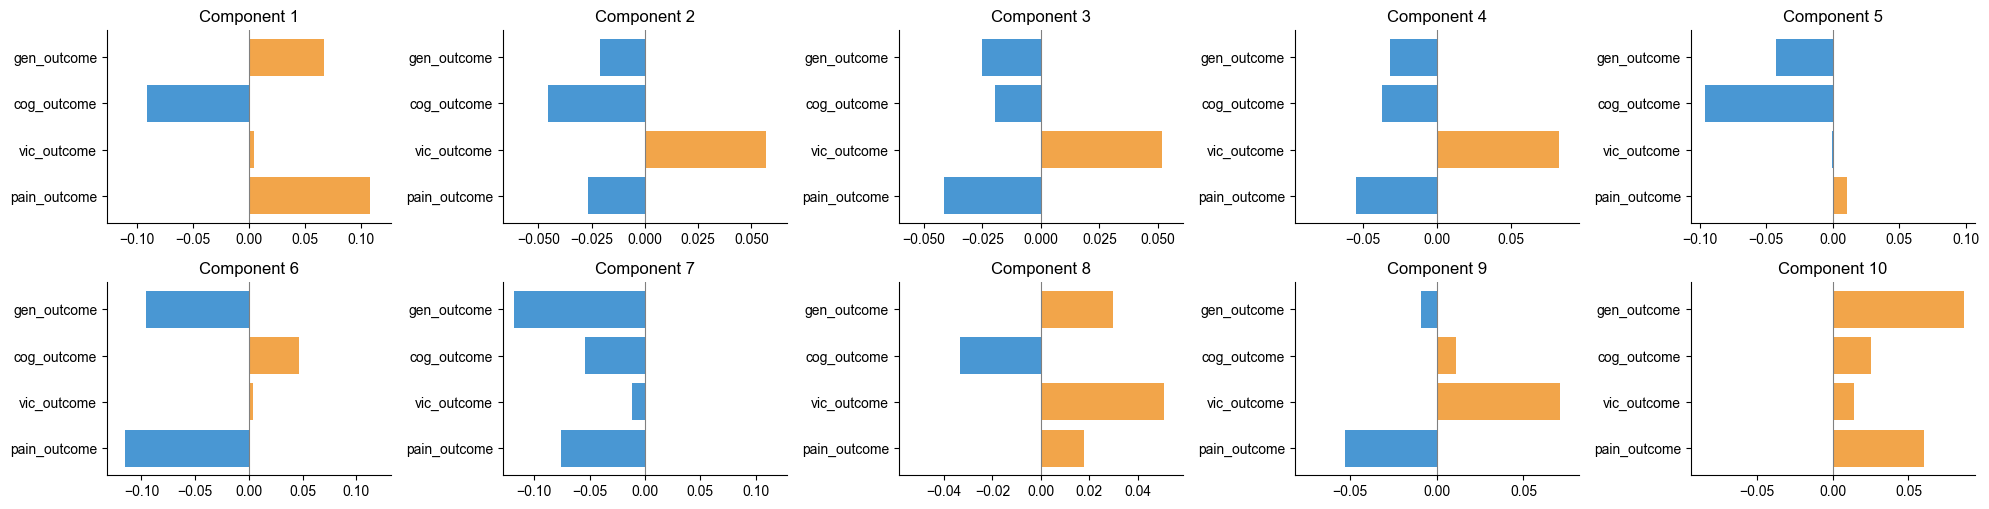

In [181]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Set font properties globally for all plots
matplotlib.rcParams['font.size'] = 10  # You can change the size here
matplotlib.rcParams['font.family'] = 'sans-serif'  # Change the font family if needed
matplotlib.rcParams['font.sans-serif'] = ['Arial']  # Or any other sans-serif font

# Assuming 'pls_model' is your fitted PLS model and 'Y' is your Y matrix with columns
y_loadings = pls_model.y_loadings_
column_names =['pain_outcome', 'vic_outcome', 'cog_outcome', 'gen_outcome'] #["Cue contrasts", "Stim. intensity contrasts", "Expectation rating", "Outcome rating", "NPS (pos)"]

# We want to create a 4x5 grid of plots, one for each component
n_rows = 4
n_cols = 5
n_components = y_loadings.shape[1]  # This should be 20 as per your model

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 10))  # Adjust the figsize accordingly

# Define the bar width
bar_width = 0.8

for i in range(n_components):
    row = i // n_cols
    col = i % n_cols
    ax = axes[row, col]
    loadings = y_loadings[:, i]
    
    # Color bars based on their value
    colors = ['#4997D3' if x < 0 else '#F2A54A' for x in loadings]
    # Set the y-ticks to match the number of column names
    ax.set_yticks(np.arange(len(column_names)))
    # Create a horizontal bar plot with colors and narrow bars
    bars = ax.barh(column_names, loadings, color=colors, height=bar_width)
    
    ax.set_title(f'Component {i+1}')
    ax.set_yticklabels(column_names, rotation=0)
    ax.axvline(0, color='grey', linewidth=0.8)  # Add a vertical line at x=0 for the zero point

    # Set the x-axis limits to be symmetrical based on the largest magnitude loading
    max_loading = np.max(np.abs(loadings))
    se = np.std(loadings)/len(loadings)
    ax.set_xlim([-max_loading-se, max_loading+se])
    
    # Optional: Remove the axes for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(True)  # Add the bottom spine for the horizontal X axis
    ax.spines['left'].set_visible(True)  # Retain the left spine to have a reference line for zero

# Hide any unused subplots if the number of components is less than the number of subplot slots
for i in range(n_components, n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    fig.delaxes(axes[row][col])

fig.tight_layout()  # Adjust the layout to make sure there's no overlap
plt.show()


# (5) UMAP 3d plot X loadings

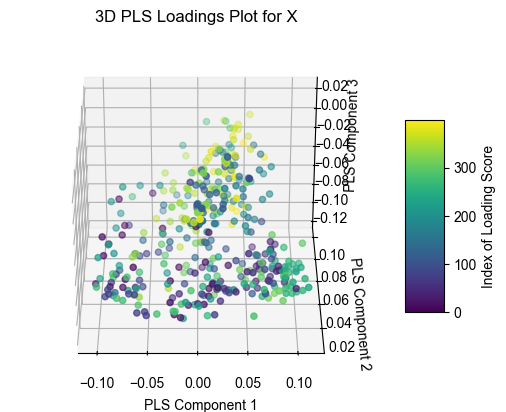

In [184]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming pls_model.x_loadings_ is your data
# For demonstration, let's create a mock x_loadings_ array
# pls_model.x_loadings_ = np.random.rand(100, 3)  # Mock data; replace with your actual data

# Calculate the indices for each loading score, which will be used for coloring
indices = np.arange(pls_model.x_loadings_.shape[0]) # ( N x brain components which is 20)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=270)  # Adjust these values to change the rotation

# Use the indices as color values and specify a colormap
scatter = ax.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 2], pls_model.x_loadings_[:, 1], c=indices, cmap='viridis') # (400 x 20)

ax.set_xlabel('PLS Component 1')
ax.set_ylabel('PLS Component 2')
ax.set_zlabel('PLS Component 3')
ax.set_title('3D PLS Loadings Plot for X')

# Add a colorbar
fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=5, label='Index of Loading Score')

plt.show()


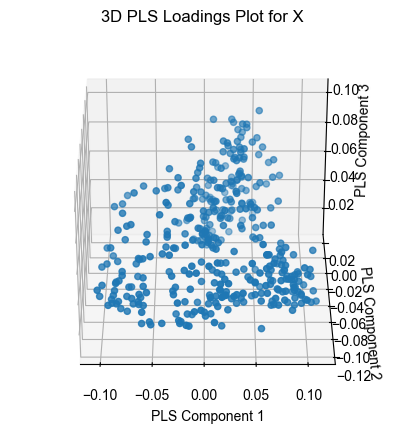

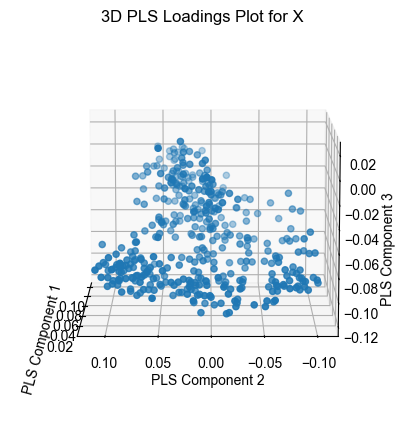

Text(0.5, 0.92, '3D PLS Scores Plot')

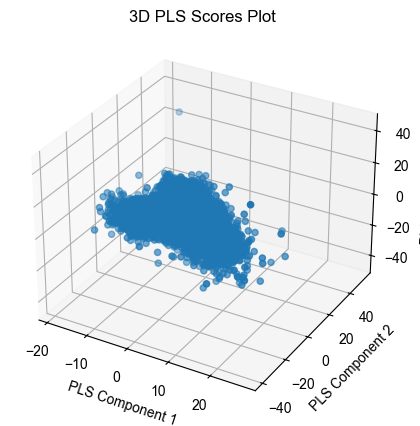

In [185]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import for 3D plotting
from sklearn.cross_decomposition import PLSRegression

# Assume X and Y are your data
# Assume pls_model is your trained PLSRegression model

# Loadings plot for X in 3D
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=270) # Adjust these values to change the rotation

ax.scatter(pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1], pls_model.x_loadings_[:, 2])
ax.set_xlabel('PLS Component 1')
ax.set_ylabel('PLS Component 2')
ax.set_zlabel('PLS Component 3')
ax.set_title('3D PLS Loadings Plot for X')
# You can annotate points with variable names here
plt.show()
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10, azim=180)
ax.scatter(pls_model.x_loadings_[:, 2], pls_model.x_loadings_[:, 0], pls_model.x_loadings_[:, 1])
ax.set_xlabel('PLS Component 1')
ax.set_ylabel('PLS Component 2')
ax.set_zlabel('PLS Component 3')
ax.set_title('3D PLS Loadings Plot for X')
plt.show()
# Scores plot in 3D
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pls_model.x_scores_[:, 0], pls_model.x_scores_[:, 1], pls_model.x_scores_[:, 2])
ax.set_xlabel('PLS Component 1')
ax.set_ylabel('PLS Component 2')
ax.set_zlabel('PLS Component 3')
ax.set_title('3D PLS Scores Plot')
# If you have labels for each sample, you can color code them here
# plt.show()


## (5)-2 UMAP plot X scores


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1440/2630655175.py:21: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral',c=colors, s=5)


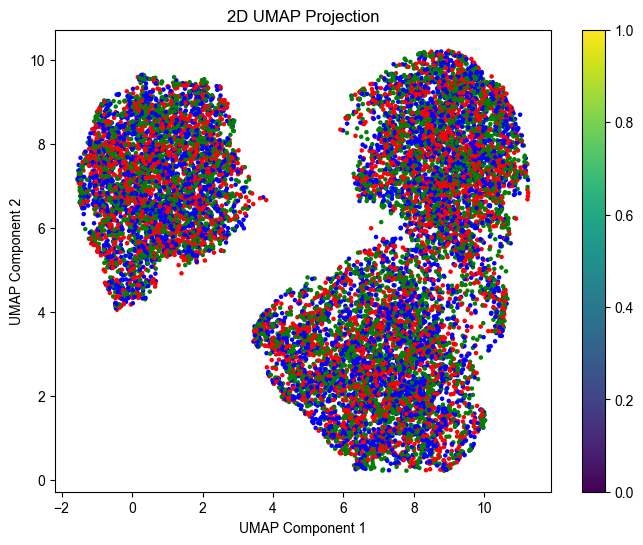

In [204]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Assume 'data' is your dataset with many components (e.g., 20)

# Initialize and fit UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(pls_model.x_scores_)
# color = cleanbehdf.iloc[train_val_idx]['runtype']
categories = beh_dropna.iloc[train_val_idx]['runtype']
color_map = {
    'pain': 'red',
    'vicarious': 'green',
    'cognitive': 'blue'
}
colors = categories.map(color_map)

# Plotting the 2D visualization
plt.figure(figsize=(8, 6))
plt.scatter(embedding[:, 0], embedding[:, 1], cmap='Spectral',c=colors, s=5)
plt.title('2D UMAP Projection')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar()
plt.show()


In [183]:
embedding_3d.shape

(4052, 3)

>>> * PLS model X scores: (14235, 10)


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


>>> * Embedding 3d: (14235, 3)


/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1440/2816270352.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],c=colors, cmap=cmap, s=5)


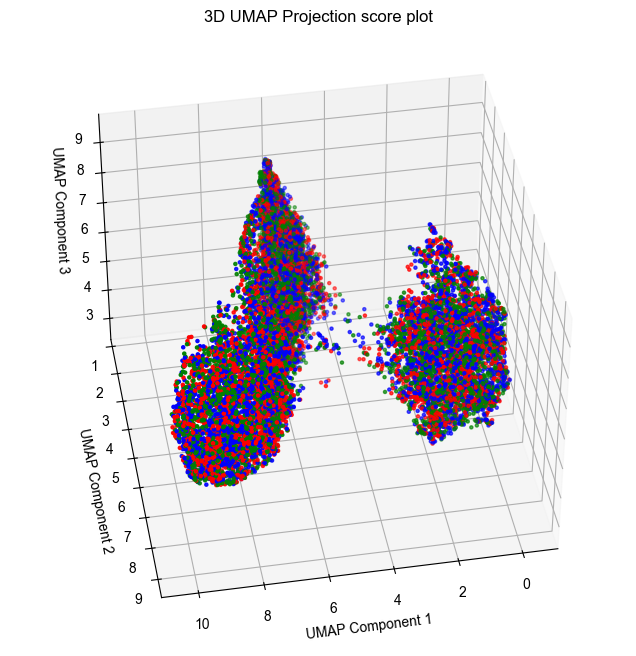

In [210]:
from mpl_toolkits.mplot3d import Axes3D

print(f">>> * PLS model X scores: {pls_model.x_scores_.shape}")
# Initialize and fit UMAP for 3D
reducer_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(pls_model.x_scores_)
categories = beh_dropna.iloc[train_val_idx]['runtype']
color_map = {
    'pain': 'red',
    'vicarious': 'green',
    'cognitive': 'blue'
}
colors = categories.map(color_map)

print(f">>> * Embedding 3d: {embedding_3d.shape}")
# colors = np.abs(pls_model.x_scores_[:, 2])  # Absolute value of the first component loadings

# Plotting the 3D visualization
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=40, azim=80) # Adjust these values to change the rotation
scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],c=colors, cmap=cmap, s=5)
ax.set_title('3D UMAP Projection score plot')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
plt.show()


>>> * PLS model X scores: (4558, 20)


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


>>> * Embedding 3d: (4558, 3)


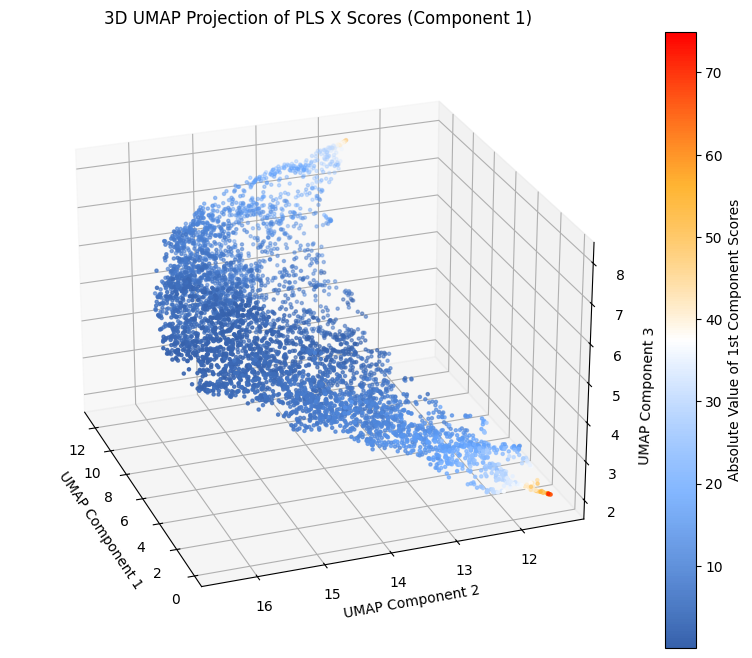

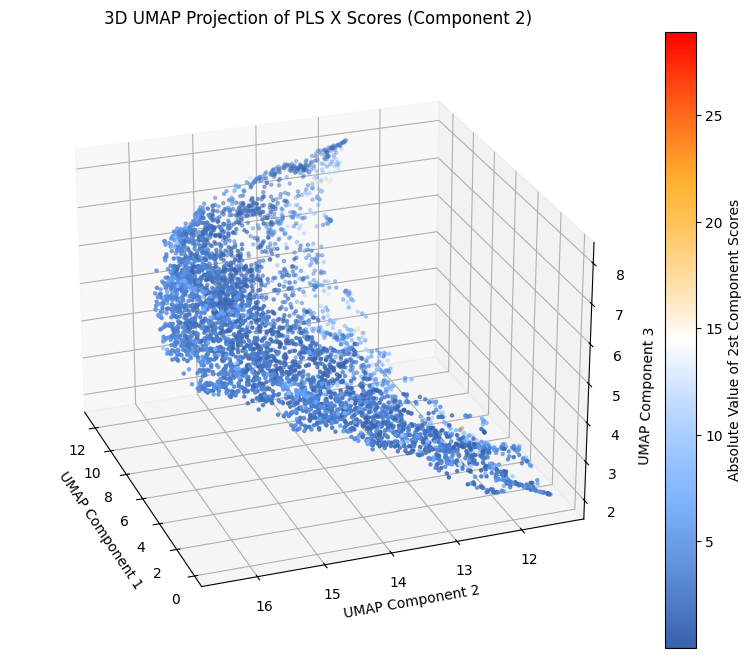

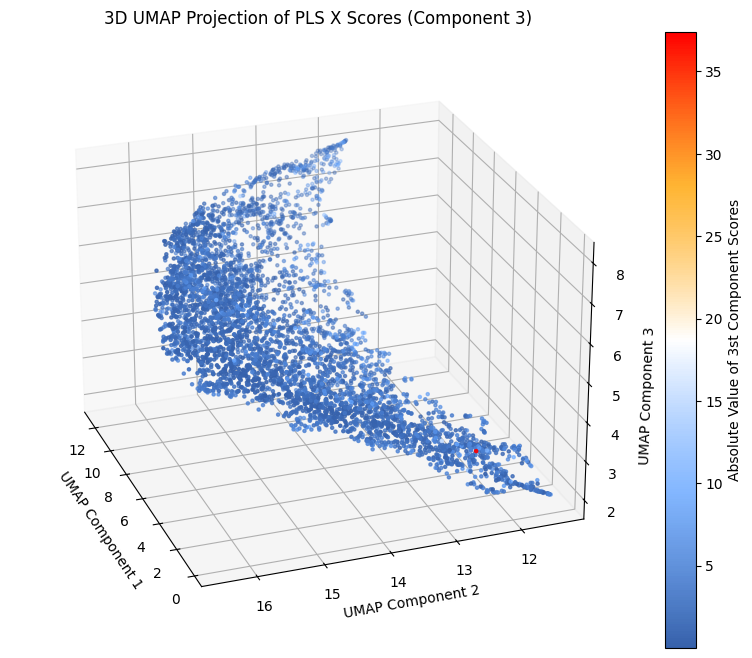

In [369]:
from mpl_toolkits.mplot3d import Axes3D
import umap
import matplotlib.pyplot as plt
import numpy as np

# Assuming pls_model.x_scores_ is already defined
print(f">>> * PLS model X scores: {pls_model.x_scores_.shape}")

# Initialize and fit UMAP for 3D
reducer_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(pls_model.x_scores_)

print(f">>> * Embedding 3d: {embedding_3d.shape}")

# Loop to create 3 plots for the 1st, 2nd, and 3rd component scores
for i in range(3):
    color_metric = np.abs(pls_model.x_scores_[:, i])  # Absolute value of the i-th component scores
    
    # Plotting the 3D visualization
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=160)  # Adjust these values to change the rotation
    scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=color_metric, cmap=cmap, s=5)
    ax.set_title(f'3D UMAP Projection of PLS X Scores (Component {i+1})')
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    ax.set_zlabel('UMAP Component 3')
    
    # Adding a color bar with a label indicating the component number
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(f'Absolute Value of {i+1}st Component Scores')
    
    plt.show()


## (5)-3 UMAP X loadings

(array([1032., 1753., 1453.,  480.,  504.,  924., 1944., 2802., 2363.,
         980.]),
 array([-1.5536288 , -0.27392769,  1.00577343,  2.28547454,  3.56517577,
         4.84487677,  6.124578  ,  7.40427923,  8.68397999,  9.96368122,
        11.24338245]),
 <BarContainer object of 10 artists>)

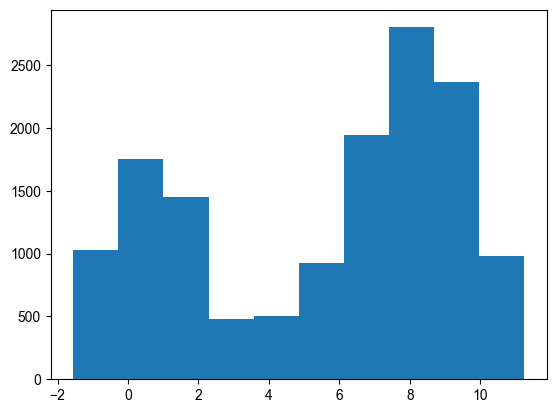

In [211]:
plt.hist(embedding[:, 0])


(array([[  0.,   3.,  52.,  56., 148., 107.,  34.,   0.,   0.,   0.],
        [  0.,  38., 212., 119.,  31.,   0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0., 144., 220.,  36.,   0.,   0.,   0.],
        [  0.,  21.,  66.,  93., 127.,  79.,  13.,   1.,   0.,   0.],
        [  0.,   9.,  50., 128., 127.,  38.,  27.,  15.,   6.,   0.],
        [  0.,  11.,  50., 118., 127.,  52.,  24.,  12.,   3.,   3.],
        [  1.,  17.,  65.,  96., 102.,  84.,  25.,   9.,   1.,   0.],
        [  4.,  15.,  54.,  88., 140.,  61.,  27.,  11.,   0.,   0.],
        [  5.,  14.,  35., 129., 135.,  49.,  19.,   5.,   1.,   8.],
        [  5.,  12.,  54., 106., 129.,  54.,  22.,  14.,   4.,   0.]]),
 array([-0.19127931, -0.14598367, -0.10068803, -0.05539239, -0.01009675,
         0.03519889,  0.08049453,  0.12579017,  0.17108581,  0.21638145,
         0.26167709]),
 <a list of 10 BarContainer objects>)

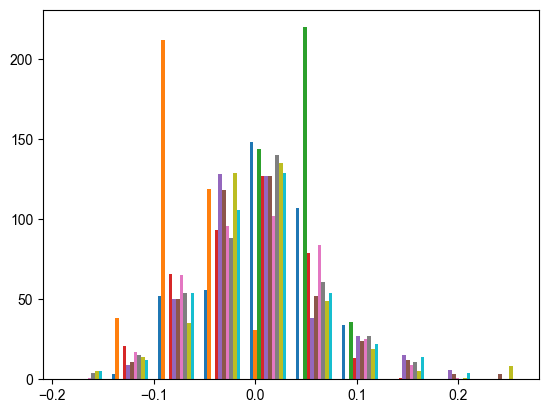

In [212]:
plt.hist(pls_model.x_loadings_)

In [213]:
pls_model.x_loadings_.shape

(400, 10)

/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


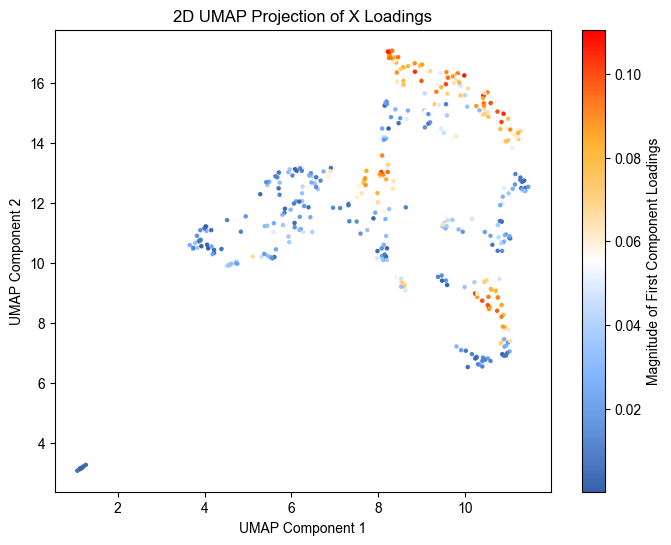

In [214]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Assume pls_model.x_loadings_ is your loadings matrix
x_loadings = pls_model.x_loadings_

# Initialize and fit UMAP
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(x_loadings)

# Example: Color by the magnitude of loadings for the first component
color_metric = np.abs(x_loadings[:, 0])  # Absolute value of the first component loadings

plt.figure(figsize=(8, 6))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=color_metric, cmap=cmap, s=5)
plt.title('2D UMAP Projection of X Loadings')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.colorbar(scatter, label='Magnitude of First Component Loadings')
plt.show()


>>> * PLS model X scores: (400, 10)


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


>>> * Embedding 3d: (400, 3)


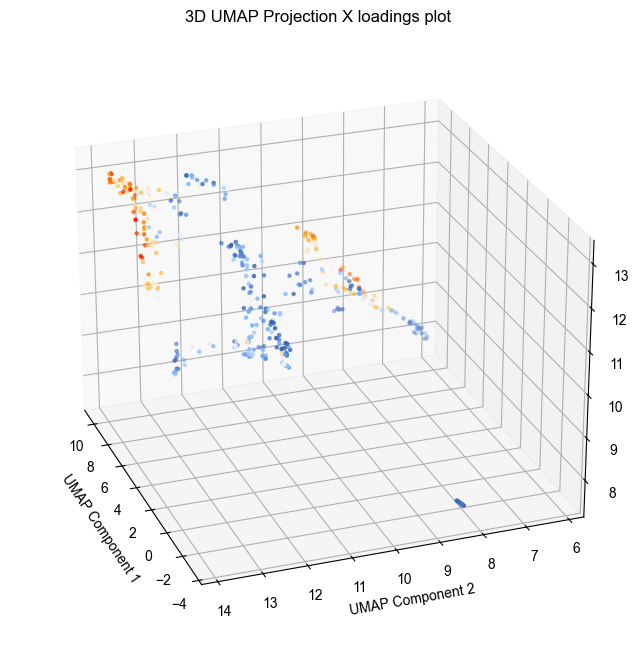

In [215]:
from mpl_toolkits.mplot3d import Axes3D

print(f">>> * PLS model X scores: {pls_model.x_loadings_.shape}")
# Initialize and fit UMAP for 3D
reducer_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(pls_model.x_loadings_)
print(f">>> * Embedding 3d: {embedding_3d.shape}")
# Plotting the 3D visualization
color_metric = np.abs(x_loadings[:, 0])  # Absolute value of the first component loadings

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=25, azim=160) # Adjust these values to change the rotation
scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2],  c=color_metric,cmap=cmap, s=5)
ax.set_title('3D UMAP Projection X loadings plot')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')
plt.show()


>>> * PLS model X scores: (400, 10)


/Users/h/miniconda3/envs/spacetop/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


>>> * Embedding 3d: (400, 3)


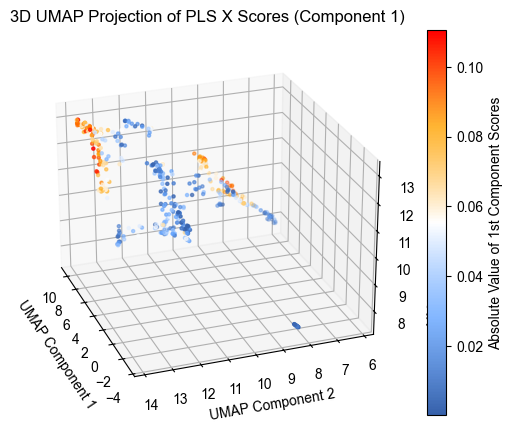

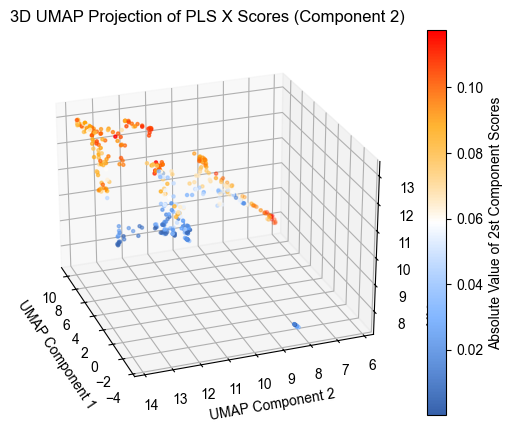

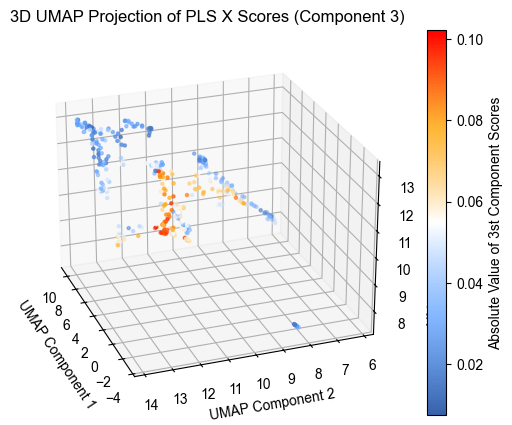

In [216]:
from mpl_toolkits.mplot3d import Axes3D
import umap
import matplotlib.pyplot as plt
import numpy as np

# Assuming pls_model.x_scores_ is already defined
print(f">>> * PLS model X scores: {pls_model.x_loadings_.shape}")

# Initialize and fit UMAP for 3D
reducer_3d = umap.UMAP(n_components=3, random_state=42)
embedding_3d = reducer_3d.fit_transform(pls_model.x_loadings_)

print(f">>> * Embedding 3d: {embedding_3d.shape}")

# Loop to create 3 plots for the 1st, 2nd, and 3rd component scores
for i in range(3):
    color_metric = np.abs(pls_model.x_loadings_[:, i])  # Absolute value of the i-th component scores
    
    # Plotting the 3D visualization
    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(elev=25, azim=160)  # Adjust these values to change the rotation
    scatter = ax.scatter(embedding_3d[:, 0], embedding_3d[:, 1], embedding_3d[:, 2], c=color_metric, cmap=cmap, s=5)
    ax.set_title(f'3D UMAP Projection of PLS X Scores (Component {i+1})')
    ax.set_xlabel('UMAP Component 1')
    ax.set_ylabel('UMAP Component 2')
    ax.set_zlabel('UMAP Component 3')
    
    # Adding a color bar with a label indicating the component number
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label(f'Absolute Value of {i+1}st Component Scores')
    
    plt.show()


# R matrix

R = W(P'W)inv

In [217]:
pls_model.x_weights_.shape

(400, 10)

In [218]:
R= pls_model.x_weights_ @ np.linalg.inv(pls_model.x_loadings_ .T @ pls_model.x_weights_)

In [219]:
R.shape

(400, 10)

In [220]:
Tnew = X @ R

# R2 score

In [221]:
r2 = pls_model.score(X, Y)
r2

0.41695595226794174

### B.4.c VIP scores

Variable Importance in Projection (VIP) scores 

VIP score: measures the importance of each feature in pLS-R with respect to predictive power of model. 
Which feature contributes most to the model's ability to predict response variables

/var/folders/bv/b3r94k7n0bq727c1_2xtykpw0000gp/T/ipykernel_1440/3946865287.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  vips[i] = np.sqrt(p * (s.T @ weight) / total_s)


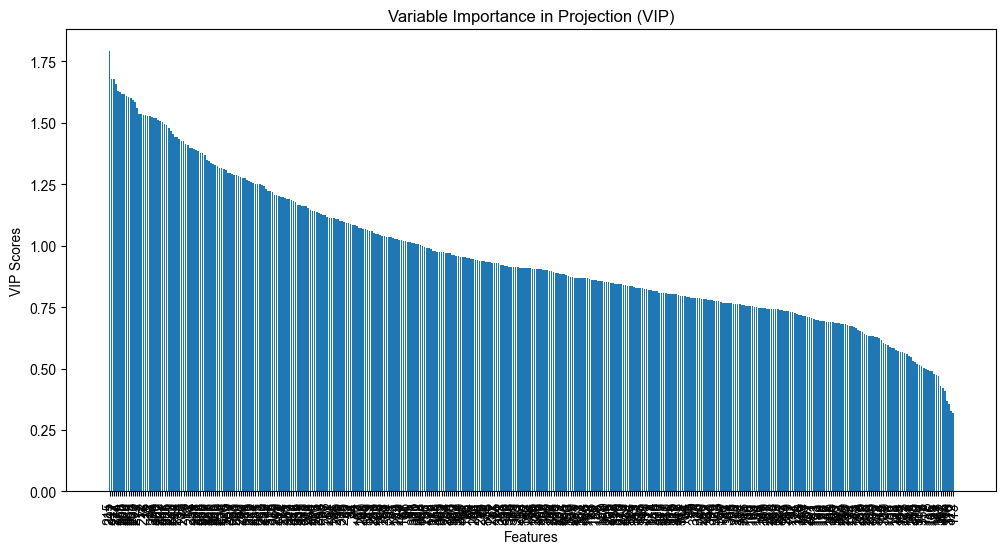

In [226]:
import numpy as np

def calculate_vip(model, X):
    t = model.x_scores_  # scores
    w = model.x_weights_  # weights
    q = model.y_loadings_  # y loadings

    p, h = w.shape
    vips = np.zeros((p,))

    s = np.diag(t.T @ t @ q.T @ q).reshape(h, -1)
    total_s = np.sum(s)

    for i in range(p):
        weight = np.array([(w[i, j] / np.linalg.norm(w[:, j]))**2 for j in range(h)])
        vips[i] = np.sqrt(p * (s.T @ weight) / total_s)

    return vips

import matplotlib.pyplot as plt

# Assuming `pls_model` is your fitted PLS model
vip_scores = calculate_vip(pls_model, X)

# Sort the VIP scores (and keep track of the feature names if you have them)
sorted_indices = np.argsort(vip_scores)[::-1]
sorted_vip_scores = vip_scores[sorted_indices]
feature_names = np.arange(400)#["stim_con", "expectrating", "outcomerating", "NPSpos"]
# feature_names = ["pain_cue", "vic_cue", "cog_cue", "gen_cue"]
feature_names_sorted = np.array(feature_names)[sorted_indices]  # Replace feature_names with your actual feature names

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_vip_scores)), sorted_vip_scores, tick_label=feature_names_sorted)
plt.xlabel('Features')
plt.ylabel('VIP Scores')
plt.title('Variable Importance in Projection (VIP)')
plt.xticks(rotation=90)  # Rotate feature names for readability
plt.show()


# (6) heatmap: loading map

Text(0.5, 1.0, 'X loadings for the first 4 components')

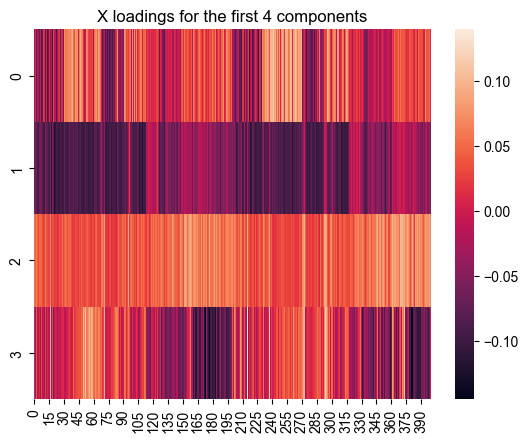

In [227]:
xloadings = np.vstack([pls_model.x_loadings_[:, 0],
pls_model.x_loadings_[:, 1],
pls_model.x_loadings_[:, 2],
pls_model.x_loadings_[:, 3]]
)
sns.heatmap(xloadings)
plt.title("X loadings for the first 4 components")

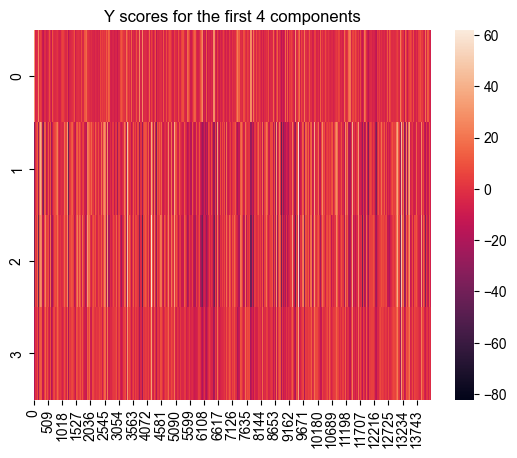

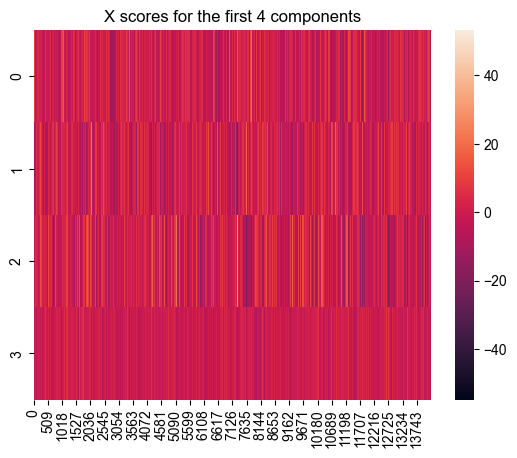

In [228]:
yscores = np.vstack([pls_model.y_scores_[:, 0],
pls_model.y_scores_[:, 1],
pls_model.y_scores_[:, 2],
pls_model.y_scores_[:, 3]]
)
sns.heatmap(yscores)
plt.title("Y scores for the first 4 components")
plt.show()
xscores = np.vstack([pls_model.x_scores_[:, 0],
pls_model.x_scores_[:, 1],
pls_model.x_scores_[:, 2],
pls_model.x_scores_[:, 3]]
)
sns.heatmap(xscores)
plt.title("X scores for the first 4 components")
plt.show()

# (7) X loadings (brain)

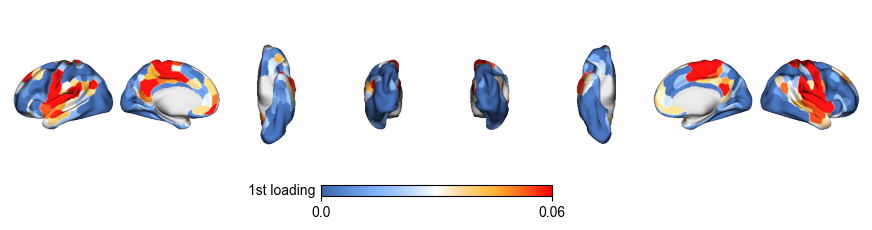

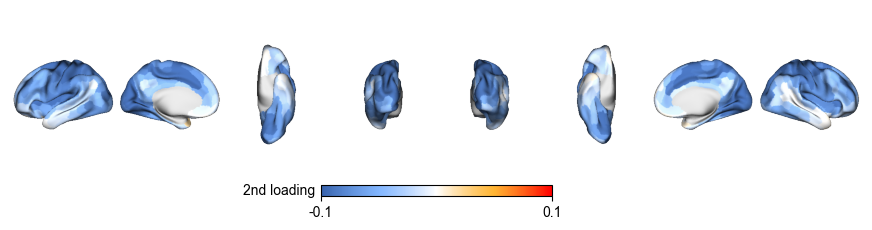

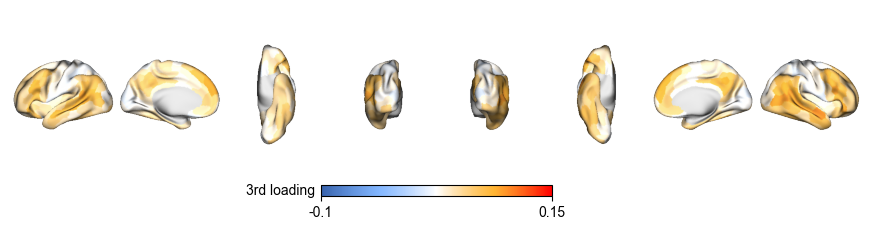

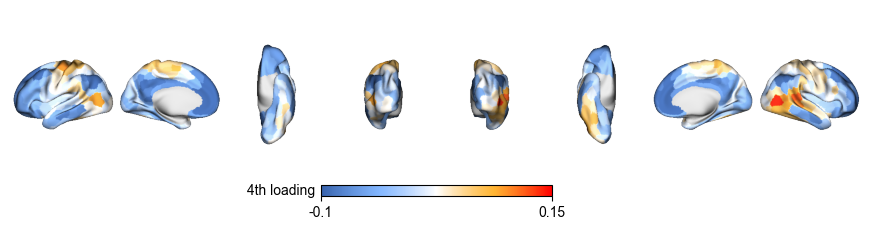

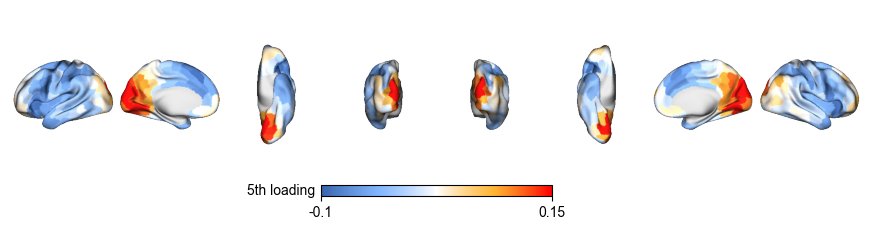

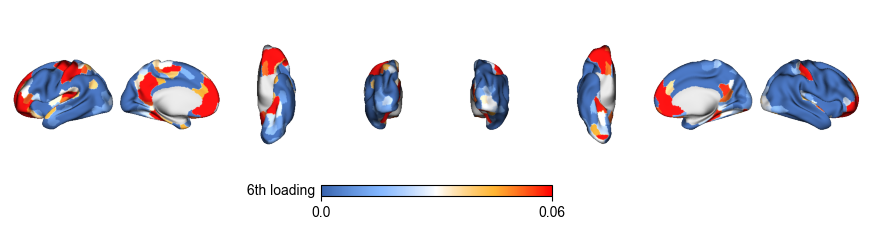

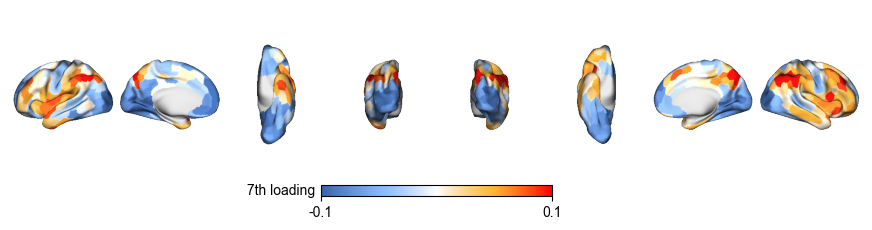

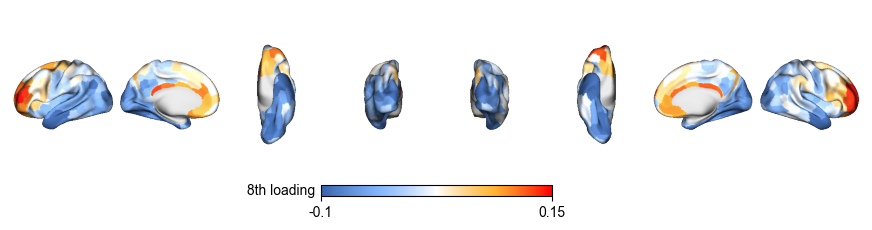

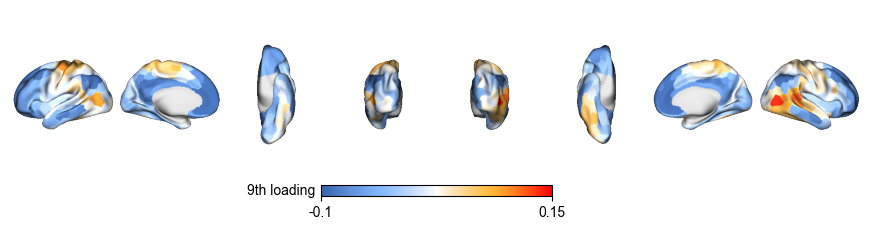

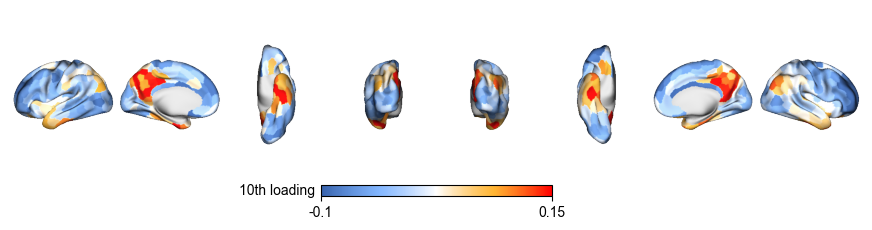

In [229]:

# beta1 = coefficients_per_fold[1][0,:] + intercepts_per_fold[1][0]
loading1 = parc.inverse_transform(pls_model.x_loadings_[:, 0])
fig = plot_brain_surfaces(image=loading1, cbar_label='1st loading', cmap=cmap, color_range=(0,0.06))
plt.show()

loading2 = parc.inverse_transform(pls_model.x_loadings_[:, 1])
fig = plot_brain_surfaces(image=loading2, cbar_label='2nd loading', cmap=cmap, color_range=(-0.1,0.1))
plt.show()

loading3 = parc.inverse_transform(pls_model.x_loadings_[:, 2])
fig = plot_brain_surfaces(image=loading3, cbar_label='3rd loading', cmap=cmap, color_range=(-0.1,0.15))
plt.show()

loading4 = parc.inverse_transform(pls_model.x_loadings_[:, 3])
fig = plot_brain_surfaces(image=loading4, cbar_label='4th loading', cmap=cmap, color_range=(-0.1,0.15))
plt.show()

loading5 = parc.inverse_transform(pls_model.x_loadings_[:, 4])
plot_brain_surfaces(image=loading5, cbar_label='5th loading', cmap=cmap, color_range=(-0.1,0.15))
plt.show()



loading6 = parc.inverse_transform(pls_model.x_loadings_[:, 5])
plot_brain_surfaces(image=loading6, cbar_label='6th loading', cmap=cmap, color_range=(0,0.06))
plt.show()

loading7 = parc.inverse_transform(pls_model.x_loadings_[:, 6])
plot_brain_surfaces(image=loading7, cbar_label='7th loading', cmap=cmap, color_range=(-0.1,0.1))
plt.show()

loading8 = parc.inverse_transform(pls_model.x_loadings_[:, 7])
plot_brain_surfaces(image=loading8, cbar_label='8th loading', cmap=cmap, color_range=(-0.1,0.15))
plt.show()

loading9 = parc.inverse_transform(pls_model.x_loadings_[:, 8])
fig = plot_brain_surfaces(image=loading4, cbar_label='9th loading', cmap=cmap, color_range=(-0.1,0.15))
plt.show()

loading10 = parc.inverse_transform(pls_model.x_loadings_[:, 9])
fig = plot_brain_surfaces(image=loading10, cbar_label='10th loading', cmap=cmap, color_range=(-0.1,0.15))
plt.show()

## (7)-1 loadings per factor

__________________________ Gen + pain _____________________________


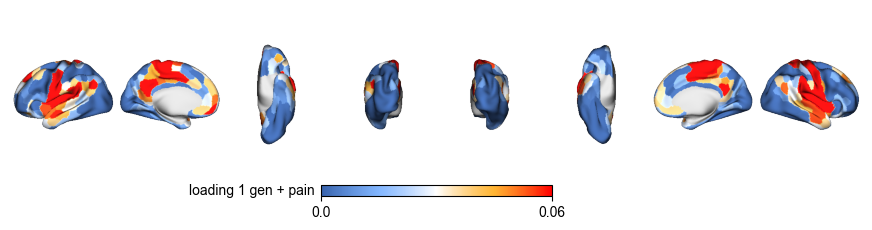

__________________________ pain _____________________________


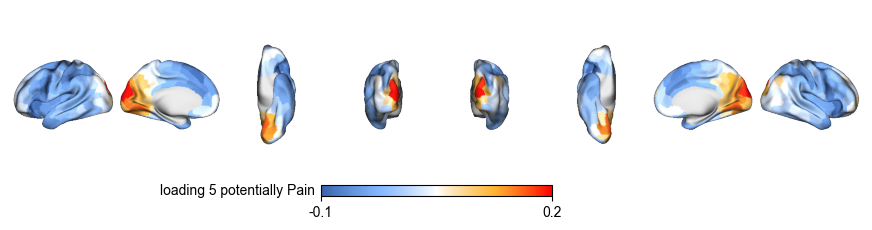

__________________________ vic _____________________________


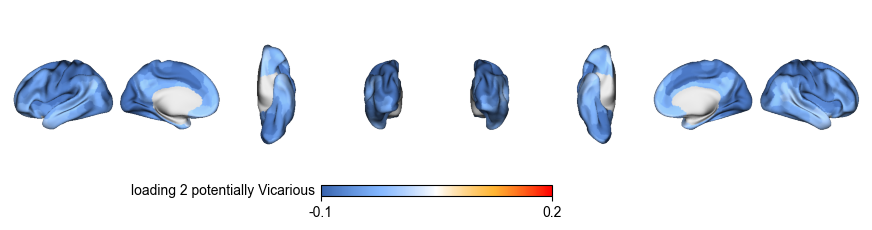

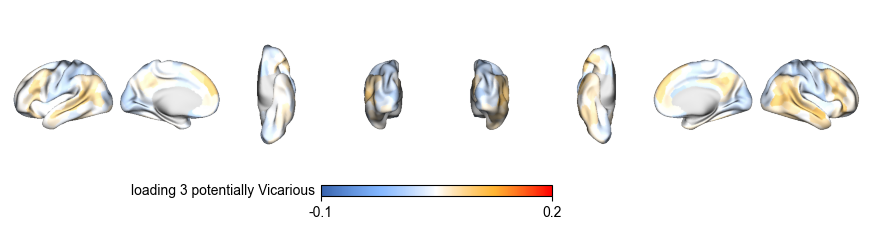

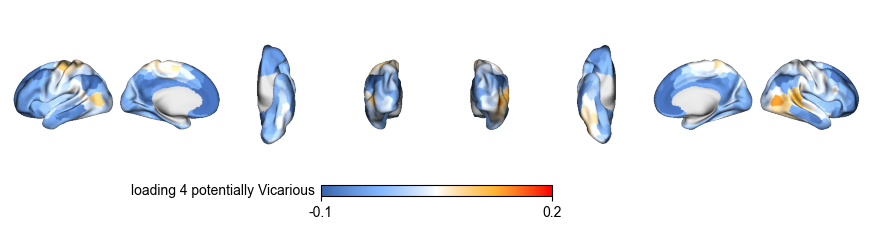

__________________________ cog _____________________________


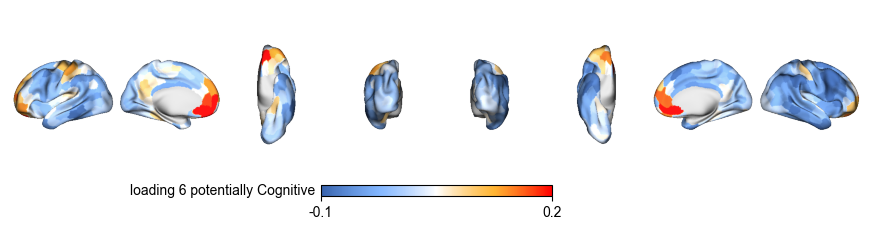

__________________________ what? _____________________________


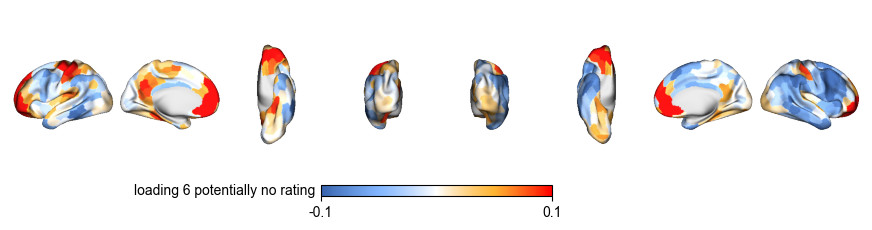

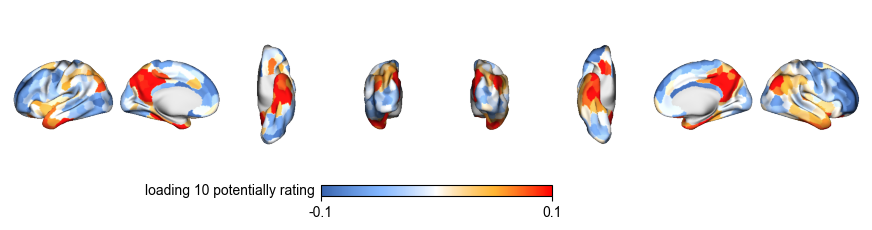

In [230]:
# plt.hist(pls_model.x_loadings_[:, 0])
print("__________________________ Gen + pain _____________________________")
loading1 = parc.inverse_transform(pls_model.x_loadings_[:, 0])
fig1 = plot_brain_surfaces(image=loading1, cbar_label='loading 1 gen + pain', cmap=cmap, color_range=(0,0.06))
plt.show()

# loading3 = parc.inverse_transform(pls_model.x_loadings_[:, 2])
# fig3 = plot_brain_surfaces(image=loading3, cbar_label='loading 3 potentially NPS', cmap=cmap, color_range=(-0.1,0.1))
# plt.show()

# loading12 = parc.inverse_transform(pls_model.x_loadings_[:, 11])
# fig = plot_brain_surfaces(image=loading12, cbar_label='loading 12 potentially NPS', cmap=cmap, color_range=(-0.1,0.1))
# plt.show()
print("__________________________ pain _____________________________")
comp_ind = 5
loading = parc.inverse_transform(pls_model.x_loadings_[:, comp_ind-1])
plot_brain_surfaces(image=loading, cbar_label=f'loading {comp_ind} potentially Pain', cmap=cmap, color_range=(-0.1,0.2))
plt.show()

print("__________________________ vic _____________________________")
comp_ind = 2
loading = parc.inverse_transform(pls_model.x_loadings_[:, comp_ind-1])
plot_brain_surfaces(image=loading, cbar_label=f'loading {comp_ind} potentially Vicarious', cmap=cmap, color_range=(-0.1,0.2))
plt.show()

comp_ind = 3
loading = parc.inverse_transform(pls_model.x_loadings_[:, comp_ind-1])
plot_brain_surfaces(image=loading, cbar_label=f'loading {comp_ind} potentially Vicarious', cmap=cmap, color_range=(-0.1,0.2))
plt.show()

comp_ind = 4
loading = parc.inverse_transform(pls_model.x_loadings_[:, comp_ind-1])
plot_brain_surfaces(image=loading, cbar_label=f'loading {comp_ind} potentially Vicarious', cmap=cmap, color_range=(-0.1,0.2))
plt.show()

print("__________________________ cog _____________________________")
comp_ind = 6
loading = parc.inverse_transform(pls_model.x_loadings_[:, comp_ind-1])
plot_brain_surfaces(image=loading, cbar_label=f'loading {comp_ind} potentially Cognitive', cmap=cmap, color_range=(-0.1,0.2))
plt.show()

print("__________________________ what? _____________________________")
comp_ind = 6
loading4 = parc.inverse_transform(pls_model.x_loadings_[:, comp_ind-1])
fig = plot_brain_surfaces(image=loading4, cbar_label=f'loading {comp_ind} potentially no rating', cmap=cmap, color_range=(-0.1,0.1))
plt.show()

comp_ind = 10
loading4 = parc.inverse_transform(pls_model.x_loadings_[:, comp_ind-1])
fig = plot_brain_surfaces(image=loading4, cbar_label=f'loading {comp_ind} potentially rating', cmap=cmap, color_range=(-0.1,0.1))
plt.show()


# loading4 = parc.inverse_transform(pls_model.x_loadings_[:, 3])
# fig = plt.figure(figsize=(4,3))
# plt.hist(pls_model.x_loadings_[:, 3])
# plot_brain_surfaces(image=loading4, cbar_label='4th loading', cmap=cmap, color_range=(-0.1,0.15))

# loading5 = parc.inverse_transform(pls_model.x_loadings_[:, 4])
# fig = plt.figure(figsize=(4,3))
# plt.hist(pls_model.x_loadings_[:, 4])
# plot_brain_surfaces(image=loading5, cbar_label='5th loading', cmap=cmap, color_range=(-0.1,0.15))

# (8) beta maps

In [231]:
print(f"* intercept per fold: {intercepts_per_fold[0]}")
print(f"* coefficients shape: {coefficients_per_fold[1].shape}")
# print(f"* inner scores: {inner_scores[0]}")

* intercept per fold: [20.82728768  9.39798627  9.87840103 10.12972632]
* coefficients shape: (4, 400)


beta 0 shape: (400,)
19.353659436158107, 21.93708051198928


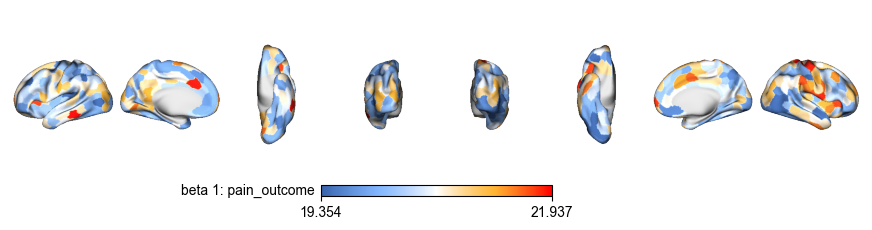

beta 1 shape: (400,)
8.957520956925414, 10.107427835866888


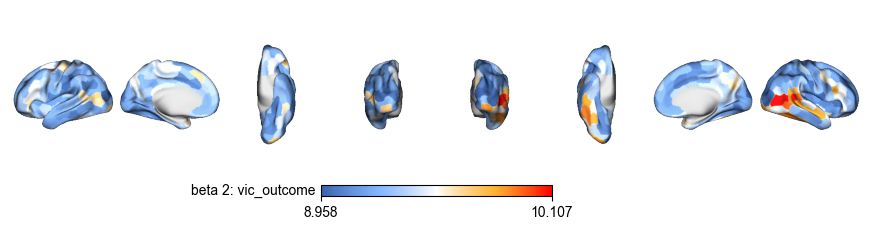

beta 2 shape: (400,)
9.048495222808121, 10.199327749445185


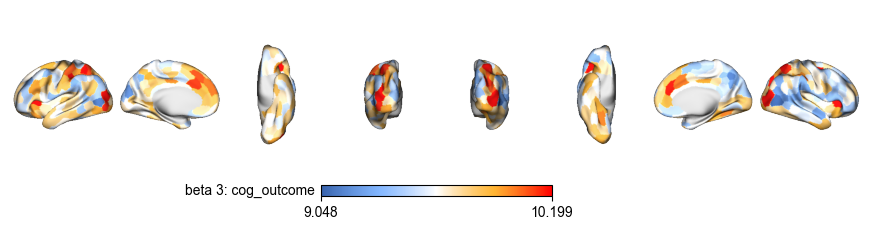

beta 3 shape: (400,)
8.404635249832065, 10.992460206321892


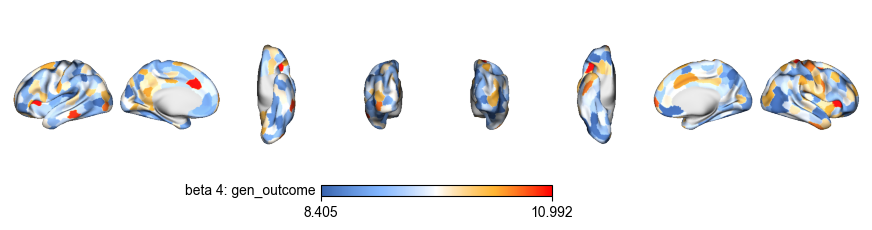

In [233]:
beta_ind = 0
factor_name = ['pain_outcome', 'vic_outcome', 'cog_outcome', 'gen_outcome']
# color_range = [(0.95, 1.05),(-0.04, 0.075),(2.5, 9.5), (3,9), (.55, 1.15) ]
for beta_ind in range(len(factor_name)):
    coef_stack = []; intercept_stack = []
    for i in range(len(coefficients_per_fold)):
        coef_stack.append(coefficients_per_fold[i][beta_ind,:])
        intercept_stack.append(intercepts_per_fold[i][beta_ind])
    avg_coef = np.vstack(coef_stack).mean(axis=0)
    avg_int = np.vstack(intercept_stack).mean(axis=0)
    beta = avg_coef + avg_int
    print(f"beta {beta_ind} shape: {beta.shape}")
    max_beta = np.max(beta)
    min_beta = np.min(beta)
    sd = np.std(beta) #/ np.sqrt(len(beta))
    # ax.set_xlim([-max_beta-se, max_beta+se])
    print(f"{min_beta+sd}, {max_beta-sd}")
    beta_inv = parc.inverse_transform(beta)
    # plt.hist(beta)
    fig = plot_brain_surfaces(image=beta_inv, cbar_label=f'beta {beta_ind+1}: {factor_name[beta_ind]}', cmap=cmap, color_range=(min_beta+sd, max_beta-sd))#color_range[beta_ind])
    plt.show()

Q. how similar are the NPS maps and the PLS recovered NPS maps?

# conclusion

In [ ]:
pain is an intense stimuli. This may be driving all of the variance in GeneratorExit